# Memecoin active trading strategy on Base

- Add Aave credit

# Set up

Set up Trading Strategy data client.


In [1]:
import logging

from tradingstrategy.client import Client
from tradeexecutor.utils.notebook import setup_charting_and_output, OutputMode

client = Client.create_jupyter_client()

# Set up drawing charts in interactive vector output mode.
# This is slower. See the alternative commented option below.
# setup_charting_and_output(OutputMode.interactive)

# Set up rendering static PNG images.
# This is much faster but disables zoom on any chart.
setup_charting_and_output(OutputMode.static, image_format="png", width=1500, height=1000)


Started Trading Strategy in Jupyter notebook environment, configuration is stored in /Users/moo/.tradingstrategy


# Parameters

- Collection of parameters used in the calculations

In [2]:
import datetime

import pandas as pd

from tradingstrategy.chain import ChainId
from tradingstrategy.timebucket import TimeBucket
from tradeexecutor.strategy.cycle import CycleDuration
from tradeexecutor.strategy.parameters import StrategyParameters
from tradeexecutor.strategy.default_routing_options import TradeRouting


class Parameters:

    id = "45-eth-full-univ"

    # We trade 1h candle
    candle_time_bucket = TimeBucket.h1
    cycle_duration = CycleDuration.cycle_4h
    
    # Coingecko categories to include
    #
    # See list here: TODO
    #
    chain_id = ChainId.ethereum
    exchanges = {"uniswap-v2", "uniswap-v3"}
    
    #
    # Basket construction and rebalance parameters
    #
    min_asset_universe = 5  # How many assets we need in the asset universe to start running the index
    max_assets_in_portfolio = 9  # How many assets our basket can hold once
    allocation = 0.95  # Allocate all cash to volatile pairs
    # min_rebalance_trade_threshold_pct = 0.05  # % of portfolio composition must change before triggering rebalacne
    individual_rebalance_min_threshold_usd = 75.0  # Don't make buys less than this amount
    per_position_cap_of_pool = 0.01  # Never own more than % of the lit liquidity of the trading pool
    max_concentration = 0.20 # How large % can one asset be in a portfolio once
    min_portfolio_weight = 0.0050  # Close position / do not open if weight is less than 50 BPS
    min_signal_threshold = 0.05
    
    #P
    # Inclusion criteria parameters:
    # - We set the length of various indicators used in the inclusion criteria
    # - We set minimum thresholds neede to be included in the index to filter out illiquid pairs
    #

    # For the length of trailing sharpe used in inclusion criteria
    trailing_sharpe_bars = pd.Timedelta("14d") // candle_time_bucket.to_timedelta()  # How many bars to use in trailing sharpe indicator
    rebalance_volalitity_bars = pd.Timedelta("1d") // candle_time_bucket.to_timedelta()  # How many bars to use in volatility indicator
    returns_bars = pd.Timedelta("10d") // candle_time_bucket.to_timedelta()  # How many bars to use in volatility indicator
    rolling_volume_bars = pd.Timedelta("7d") // candle_time_bucket.to_timedelta()
    rolling_liquidity_bars = pd.Timedelta("7d") // candle_time_bucket.to_timedelta()
    ewm_span = 200  # How many bars to use in exponential moving average for trailing sharpe smoothing
    tvl_ewm_span = 200  # How many bars to use in EWM smoothing of TVLs
    min_volume = 500_000   # USD
    min_tvl_prefilter = 3_000_000  # USD - to reduce number of trading pairs for backtest-purposes only
    min_tvl = 1_000_000  # USD - set to same as above if you want to avoid any survivorship bias
    min_token_sniffer_score = 20  # 20 = AAVE

    #
    # Yield on cash
    #
    use_aave = False

    #     
    #
    # Backtesting only
    #
    backtest_start = datetime.datetime(2023, 4, 1)
    backtest_end = datetime.datetime(2025, 1, 9)
    initial_cash = 100_000

    #
    # Live only
    #
    routing = TradeRouting.default
    required_history_period = datetime.timedelta(days=2*14 + 1)
    slippage_tolerance = 0.0060  # 0.6% 
    assummed_liquidity_when_data_missings = 10_000
    

parameters = StrategyParameters.from_class(Parameters)  # Convert to AttributedDict to easier typing with dot notation

# Trading pairs and market data

- This creates the strategy universe containing pair metadata and their prices
- The universe is "masked" by simply selecting pairs on the predefined pairs list

In [3]:
import warnings

from tradingstrategy.alternative_data.coingecko import CoingeckoUniverse, categorise_pairs
from tradingstrategy.chain import ChainId
from tradingstrategy.client import Client
from tradingstrategy.pair import PandasPairUniverse
from tradingstrategy.utils.token_filter import deduplicate_pairs_by_volume
from tradingstrategy.client import Client
from tradingstrategy.client import Client
from tradingstrategy.utils.token_extra_data import filter_scams
from tradingstrategy.lending import LendingProtocolType
from tradingstrategy.utils.liquidity_filter import prefilter_pairs_with_tvl

from tradingstrategy.utils.token_filter import filter_for_trading_fee
from tradingstrategy.utils.token_filter import filter_for_quote_tokens
from tradingstrategy.utils.token_filter  import filter_for_stablecoins
from tradingstrategy.utils.token_filter import add_base_quote_address_columns
from tradingstrategy.utils.token_filter import StablecoinFilteringMode
from tradingstrategy.utils.token_filter import filter_for_derivatives


from tradeexecutor.strategy.trading_strategy_universe import TradingStrategyUniverse
from tradeexecutor.strategy.execution_context import ExecutionContext, notebook_execution_context
from tradeexecutor.strategy.universe_model import UniverseOptions
from tradeexecutor.strategy.trading_strategy_universe import TradingStrategyUniverse, load_partial_data, OHLCVCandleType
from tradeexecutor.strategy.execution_context import ExecutionContext, notebook_execution_context
from tradeexecutor.strategy.universe_model import UniverseOptions
from tradeexecutor.analysis.pair import display_strategy_universe

from eth_defi.token import USDC_NATIVE_TOKEN
from eth_defi.token import WRAPPED_NATIVE_TOKEN


# We define our main trading universe,
# and then Ethereum mainnet as a validation set
if Parameters.chain_id == ChainId.base:
    SUPPORTING_PAIRS = [
        (ChainId.base, "uniswap-v2", "WETH", "USDC", 0.0030),  
        (ChainId.base, "uniswap-v3", "cbBTC", "WETH", 0.0030),    # Only trading since October
    ]

    EXAMINED_ASSETS = [
        "AIXBT", 
        "PEPE",
        "KEYCAT",
        "WETH",
        "cbBTC"
    ]

elif Parameters.chain_id == ChainId.ethereum:
    SUPPORTING_PAIRS = [
        (ChainId.ethereum, "uniswap-v2", "WETH", "USDC", 0.0030),  
        (ChainId.ethereum, "uniswap-v3", "WBTC", "USDC", 0.0030),    # Only trading since October
    ]

    EXAMINED_ASSETS = [
        "PEPE",
        "AAVE",
        "WETH",
        "WBTC",
    ]

else:
    raise NotImplementedError("Chain not supported")


#: Needed for USDC credit
LENDING_RESERVES  = [
    (Parameters.chain_id, LendingProtocolType.aave_v3, "USDC"),
]


# Will be converted to cbBTC/ETH->USDC
VOL_PAIR = (Parameters.chain_id, "uniswap-v2", "WETH", "USDC", 0.0030)


def create_trading_universe(
    timestamp: datetime.datetime,
    client: Client,
    execution_context: ExecutionContext,
    universe_options: UniverseOptions,
) -> TradingStrategyUniverse:
    """Create the trading universe.

    - Load Trading Strategy full pairs dataset

    - Load built-in Coingecko top 1000 dataset
    
    - Get all DEX tokens for a certain Coigecko category

    - Load OHCLV data for these pairs

    - Load also BTC and ETH price data to be used as a benchmark
    """

    chain_id = Parameters.chain_id

    exchange_universe = client.fetch_exchange_universe()
    pairs_df = client.fetch_pair_universe().to_pandas()

    # Drop other chains to make the dataset smaller to work with
    chain_mask = pairs_df["chain_id"] == Parameters.chain_id.value
    pairs_df = pairs_df[chain_mask]

    # Pull out our benchmark pairs ids.
    # We need to construct pair universe object for the symbolic lookup.
    pair_universe = PandasPairUniverse(pairs_df, exchange_universe=exchange_universe)
    benchmark_pair_ids = [pair_universe.get_pair_by_human_description(desc).pair_id for desc in SUPPORTING_PAIRS]

    category_df = pairs_df
    category_df = add_base_quote_address_columns(category_df)
    category_df = filter_for_stablecoins(category_df, StablecoinFilteringMode.only_volatile_pairs)
    category_df = filter_for_derivatives(category_df)

    allowed_quotes = {
        USDC_NATIVE_TOKEN[chain_id.value].lower(),
        WRAPPED_NATIVE_TOKEN[chain_id.value].lower(),
    }

    category_df = filter_for_quote_tokens(category_df, allowed_quotes)
    category_pair_ids = category_df["pair_id"]

    our_pair_ids = list(category_pair_ids) + benchmark_pair_ids

    # From these pair ids, see what trading pairs we have on Ethereum mainnet
    pairs_df = pairs_df[pairs_df["pair_id"].isin(our_pair_ids)]

    # Limit by DEX
    pairs_df = pairs_df[pairs_df["exchange_slug"].isin(Parameters.exchanges)]

    # Get TVL data for prefilteirng
    pairs_df = prefilter_pairs_with_tvl(
        client,
        pairs_df,
        chain_id=Parameters.chain_id,
        min_tvl=Parameters.min_tvl_prefilter,
        start=Parameters.backtest_start,
        end=Parameters.backtest_end,
    )

    print(f"After TVL filter {Parameters.min_tvl_prefilter:,} USD we have {len(pairs_df)} tradeable pairs")

    # Never deduplicate supporting pars
    supporting_pairs_df = pairs_df[pairs_df["pair_id"].isin(benchmark_pair_ids)]

    # Deduplicate trading pairs - Choose the best pair with the best volume
    deduplicated_df = deduplicate_pairs_by_volume(pairs_df)
    pairs_df = pd.concat([deduplicated_df, supporting_pairs_df]).drop_duplicates(subset='pair_id', keep='first')

    # Scam filter using TokenSniffer
    pairs_df = filter_scams(pairs_df, client, min_token_sniffer_score=Parameters.min_token_sniffer_score)
    pairs_df = pairs_df.sort_values("volume", ascending=False)

    uni_v2 = pairs_df.loc[pairs_df["exchange_slug"] == "uniswap-v2"]
    uni_v3 = pairs_df.loc[pairs_df["exchange_slug"] == "uniswap-v3"]
    print(f"Pairs on Uniswap v2: {len(uni_v2)}, Uniswap v3: {len(uni_v3)}")
    dataset = load_partial_data(
        client=client,
        time_bucket=Parameters.candle_time_bucket,
        pairs=pairs_df,
        execution_context=execution_context,
        universe_options=universe_options,
        liquidity=True,
        liquidity_time_bucket=TimeBucket.d1,  
        liquidity_query_type=OHLCVCandleType.tvl_v2,
        lending_reserves=LENDING_RESERVES,
    )

    reserve_asset = USDC_NATIVE_TOKEN[chain_id.value]

    print("Creating trading universe")
    strategy_universe = TradingStrategyUniverse.create_from_dataset(
        dataset,
        reserve_asset=reserve_asset,
        forward_fill=True,  # We got very gappy data from low liquid DEX coins
    )

    # Tag benchmark/routing pairs tokens so they can be separated from the rest of the tokens
    # for the index construction.
    strategy_universe.warm_up_data()
    for pair_id in benchmark_pair_ids:
        pair = strategy_universe.get_pair_by_id(pair_id)
        pair.other_data["benchmark"] = True

    return strategy_universe

    
strategy_universe = create_trading_universe(
    None,
    client,
    notebook_execution_context,
    UniverseOptions.from_strategy_parameters_class(Parameters, notebook_execution_context)
)

display_strategy_universe(strategy_universe)


After TVL filter 3,000,000 USD we have 271 tradeable pairs
After scam filter we have 172 pairs
Scammy pair EMP - WETH, risk score nan, pool 0xe092769bc1fa5262d4f48353f90890dcc339bf80, token 0x39d5313c3750140e5042887413ba8aa6145a9bd2
Scammy pair CHEX - WETH, risk score 0.0, pool 0xd3e9895230e8fb1460852f6cda3c4b926fbc29d8, token 0x9ce84f6a69986a83d92c324df10bc8e64771030f
Scammy pair DEAI - WETH, risk score 0.0, pool 0x1385fc1fe0418ea0b4fcf7adc61fc7535ab7f80d, token 0x1495bc9e44af1f8bcb62278d2bec4540cf0c05ea
Scammy pair OLAS - WETH, risk score nan, pool 0x09d1d767edf8fa23a64c51fa559e0688e526812f, token 0x0001a500a6b18995b03f44bb040a5ffc28e45cb0
Scammy pair ATH - WETH, risk score 0.0, pool 0xd31d41dffa3589bb0c0183e46a1eed983a5e5978, token 0xbe0ed4138121ecfc5c0e56b40517da27e6c5226b
Scammy pair wQUIL - WETH, risk score 0.0, pool 0x43e7ade137b86798654d8e78c36d5a556a647224, token 0x8143182a775c54578c8b7b3ef77982498866945d
Scammy pair AMPL - WETH, risk score 0.0, pool 0xc5be99a02c6857f9eac67bbc

Loading OHLCV data for 172 pairs:   0%|          | 0/56073600 [00:00<?, ?it/s]

Loading TVL/liquidity data for 172 pairs:   0%|          | 0/172 [00:00<?, ?it/s]

Creating trading universe


base quote    exchange  fee %      type:     price  \
id                                                                 
1             WETH  USDC  uniswap-v2   0.30  benchmark   3330.81   
349            FOX  WETH  uniswap-v2   0.30     traded      0.06   
523           PAXG  WETH  uniswap-v2   0.30     traded   2685.54   
21431          WOO  WETH  uniswap-v2   0.30     traded      0.21   
29429           OM  WETH  uniswap-v2   0.30     traded      4.00   
29845         WISE  WETH  uniswap-v2   0.30     traded      0.20   
33873        SUPER  WETH  uniswap-v2   0.30     traded      1.28   
34469          ERN  WETH  uniswap-v2   0.30     traded      2.34   
37316         ELON  WETH  uniswap-v2   0.30     traded      0.00   
37520          RST  WETH  uniswap-v2   0.30     traded      0.77   
40233         WILD  WETH  uniswap-v2   0.30     traded      0.63   
50635          UFO  WETH  uniswap-v2   0.30     traded      0.00   
50980         DEXT  WETH  uniswap-v2   0.30     traded      0.45   
51724        STARL  WETH  uniswap-v2   0.30     traded      0.00   
59188        BOTTO  WETH  uniswap-v2   0.30     traded      0.88   
61381           MC  WETH  uniswap-v2   0.30     traded      0.20   
68900        FLOKI  WETH  uniswap-v2   0.30     traded      0.00   
78008          CAW  WETH  uniswap-v2   0.30     traded      0.00   
2697583        UNI  WETH  uniswap-v3   0.30     traded     13.15   
2697591       LQTY  WETH  uniswap-v3   0.30     traded      1.60   
2697602        MKR  WETH  uniswap-v3   0.30     traded   1481.56   
2697609       AAVE  WETH  uniswap-v3   0.30     traded    294.02   
2697610       LINK  WETH  uniswap-v3   0.30     traded     20.49   
2697640       SHIB  WETH  uniswap-v3   0.30     traded      0.00   
2697645        GLQ  WETH  uniswap-v3   1.00     traded      0.06   
2697647       WBTC  USDC  uniswap-v3   0.30  benchmark  94952.06   
2697689        CRV  WETH  uniswap-v3   0.30     traded      0.87   
2697712      MATIC  WETH  uniswap-v3   0.30     traded      0.46   
2697715        OVR  WETH  uniswap-v3   1.00     traded      0.30   
2697728        GRT  WETH  uniswap-v3   0.30     traded      0.21   
2697744        HEX  USDC  uniswap-v3   0.30     traded      0.00   
2697762      1INCH  USDC  uniswap-v3   1.00     traded      0.38   
2697765       WETH  USDC  uniswap-v3   0.05     traded   3340.24   
2697863       PERP  WETH  uniswap-v3   0.30     traded      0.71   
2697999       RNDR  WETH  uniswap-v3   1.00     traded      7.52   
2698316        FET  WETH  uniswap-v3   0.30     traded      1.33   
2698406      WDOGE  WETH  uniswap-v3   1.00     traded      0.34   
2698484      Metis  WETH  uniswap-v3   0.30     traded     39.24   
2698489     SHIBA2  WETH  uniswap-v3   1.00     traded      0.02   
2698975       AIOZ  WETH  uniswap-v3   1.00     traded      1.01   
2698994        LDO  WETH  uniswap-v3   0.30     traded      1.66   
2699186       AGIX  WETH  uniswap-v3   1.00     traded      0.58   
2699520        INJ  WETH  uniswap-v3   0.30     traded     21.77   
2699631        FTM  WETH  uniswap-v3   1.00     traded      0.68   
2699690       wNXM  WETH  uniswap-v3   0.30     traded     73.63   
2699978       INST  WETH  uniswap-v3   1.00     traded      5.66   
2700236       VITA  WETH  uniswap-v3   1.00     traded      4.84   
2700627       RAIL  WETH  uniswap-v3   1.00     traded      1.02   
2701707        BIT  WETH  uniswap-v3   0.30     traded      1.17   
2701808    TONCOIN  WETH  uniswap-v3   1.00     traded      5.25   
2701863        GNO  WETH  uniswap-v3   0.30     traded    254.49   
2702046       DYDX  WETH  uniswap-v3   0.30     traded      1.34   
2702115        GEL  WETH  uniswap-v3   1.00     traded      0.22   
2702167        SNX  USDC  uniswap-v3   1.00     traded      1.91   
2711765        IMX  WETH  uniswap-v3   1.00     traded      1.24   
2711819        ENS  WETH  uniswap-v3   0.30     traded     32.43   
2711827        SOL  WETH  uniswap-v3   0.30     traded    196.74   
27

### Asset to trading pair map

- Build a helper map
- Because we are operating on trading pairs, not on tokens, which are the base asset of a trading pair, we set up 
  this map to easily look up the selected trading pair by its symbol

In [4]:
from tradingstrategy.types import TokenSymbol
from tradeexecutor.state.identifier import TradingPairIdentifier

# Create base token symbol to pair map to help later
# Token
token_map: dict[TokenSymbol, TradingPairIdentifier] = {p.base.token_symbol: p for p in strategy_universe.iterate_pairs()}

# print(f"Pair count is {strategy_universe.get_pair_count()}")
# for symbol, pair in token_map.items():
#    print(f"{symbol} - #{pair.internal_id}")

# Tokens part of benchmark data, but not the strategy
benchmark_pair_ids = [p.internal_id for p in strategy_universe.iterate_pairs() if p.other_data.get("benchmark") is True]
category_pair_ids = [p.internal_id for p in strategy_universe.iterate_pairs() if p.other_data.get("benchmark") is not True]

print(f"Token map is {len(token_map)} assets")
print("Category trading pairs", len(category_pair_ids))
print("Benchmark trading pairs", len(benchmark_pair_ids))

Token map is 171 assets
Category trading pairs 170
Benchmark trading pairs 2


# Indicators

- Precalculate indicators used by the strategy

In [5]:
import pandas as pd
import numpy as np
from IPython.display import HTML

from tradeexecutor.strategy.execution_context import ExecutionContext
from tradeexecutor.strategy.pandas_trader.indicator import IndicatorSet, IndicatorSource
from tradeexecutor.strategy.parameters import StrategyParameters
from tradeexecutor.strategy.trading_strategy_universe import TradingStrategyUniverse
from tradeexecutor.strategy.pandas_trader.indicator import calculate_and_load_indicators_inline
from tradeexecutor.strategy.pandas_trader.indicator import IndicatorDependencyResolver
from tradeexecutor.state.types import USDollarAmount
from tradeexecutor.strategy.pandas_trader.indicator_decorator import IndicatorRegistry
from tradeexecutor.analysis.indicator import display_indicators


indicators = IndicatorRegistry()


@indicators.define()
def trailing_sharpe(
    close: pd.Series, 
    trailing_sharpe_bars: int
) -> pd.Series:
    """Calculate trailing 30d or so returns / standard deviation.

    :param length:
        Trailing period. 
    
    :return:
        Rolling cumulative returns / rolling standard deviation

        Note that this trailing sharpe is not annualised.
    """
    ann_factor = pd.Timedelta(days=365) / Parameters.candle_time_bucket.to_pandas_timedelta()
    returns = close.pct_change()
    mean_returns = returns.rolling(window=trailing_sharpe_bars).mean()    
    vol = returns.rolling(window=trailing_sharpe_bars).std()
    return mean_returns / vol * np.sqrt(ann_factor)


@indicators.define(dependencies=(trailing_sharpe,), source=IndicatorSource.dependencies_only_per_pair)
def trailing_sharpe_ewm(
    trailing_sharpe_bars: int,
    ewm_span: float,
    pair: TradingPairIdentifier,
    dependency_resolver: IndicatorDependencyResolver,
) -> pd.Series:
    """Expontentially weighted moving average for Sharpe.

    :param ewm_span:
        How many bars to consider in the EVM

    """
    trailing_sharpe = dependency_resolver.get_indicator_data(
        "trailing_sharpe",
        pair=pair,
        parameters={"trailing_sharpe_bars": trailing_sharpe_bars},
    )    
    ewm = trailing_sharpe.ewm(span=ewm_span)
    return ewm.mean()


@indicators.define()
def volatility(close: pd.Series, rebalance_volalitity_bars: int) -> pd.Series:
    """Calculate the rolling volatility for rebalancing the index for each decision cycle."""
    price_diff = close.pct_change()
    rolling_std = price_diff.rolling(window=rebalance_volalitity_bars).std()
    return rolling_std



@indicators.define()
def signed_volatility(close: pd.Series, rebalance_volalitity_bars: int) -> pd.Series:
    """Volatility with returns sign (profit or loss)."""
    price_diff = close.pct_change()
    rolling_std = price_diff.rolling(window=rebalance_volalitity_bars).std()

    returns =  close \
        .rolling(window=rebalance_volalitity_bars) \
        .agg(lambda x: x.iloc[-1] - x.iloc[0])
    returns_sign = returns.apply(np.sign)
    return rolling_std * returns_sign


@indicators.define()
def rolling_returns(
    close: pd.Series, 
    returns_bars: int    
) -> pd.Series:
    """Rolling returns for the signal period."""

    def _agg_func(window: pd.Series) -> float:

        if len(window) < 2:
            return 0

        try:
            return (window.iloc[-1] - window.iloc[0]) / window.iloc[0]
        except Exception as e:
            raise # Drop into the debugger here

    returns = close.rolling(window=returns_bars).agg(_agg_func)
    return returns


@indicators.define(dependencies=[rolling_returns])
def volatility_returns_indicator(
    close: pd.Series, 
    rebalance_volalitity_bars: int,
    returns_bars: int,
    pair: TradingPairIdentifier,
    dependency_resolver: IndicatorDependencyResolver
) -> pd.Series:
    """Figure out some indicator to predict the price."""

    returns = dependency_resolver.get_indicator_data(
        rolling_returns,
        parameters={"returns_bars": returns_bars},
        pair=pair,
    )

    price_diff = close.pct_change()
    rolling_std = price_diff.rolling(window=rebalance_volalitity_bars).std()
    return rolling_std * returns



@indicators.define()
def volatility_ewm(close: pd.Series, rebalance_volalitity_bars: int) -> pd.Series:
    """Calculate the rolling volatility for rebalancing the index for each decision cycle."""
    # We are operating on 1h candles, 14d window
    price_diff = close.pct_change()
    rolling_std = price_diff.rolling(window=rebalance_volalitity_bars).std()
    ewm = rolling_std.ewm(span=14*8)
    return ewm.mean()   


@indicators.define()
def mean_returns(close: pd.Series, rebalance_volalitity_bars: int) -> pd.Series:
    # Descripton: TODO
    returns = close.pct_change()
    mean_returns = returns.rolling(window=rebalance_volalitity_bars).mean()    
    return mean_returns


@indicators.define()
def rolling_cumulative_volume(volume: pd.Series, rolling_volume_bars: int) -> pd.Series:
    """Calculate rolling volume of the pair.
    
    - Used in inclusion criteria
    """
    rolling_volume = volume.rolling(window=rolling_volume_bars).sum()
    return rolling_volume


@indicators.define()
def rolling_liquidity_avg(close: pd.Series, rolling_volume_bars: int) -> pd.Series:
    """Calculate rolling liquidity average

    - This is either TVL or XY liquidity (one sided) depending on the trading pair DEX type
    
    - Used in inclusion criteria
    """
    rolling_liquidity_close = close.rolling(window=rolling_volume_bars).mean()
    return  rolling_liquidity_close

    
@indicators.define(dependencies=(rolling_cumulative_volume,), source=IndicatorSource.strategy_universe)
def volume_inclusion_criteria(   
    strategy_universe: TradingStrategyUniverse, 
    min_volume: USDollarAmount,
    rolling_volume_bars: int,
    dependency_resolver: IndicatorDependencyResolver,
) -> pd.Series:
    """Calculate pair volume inclusion criteria.

    - Avoid including illiquid / broken pairs in the set: Pair is included when it has enough volume 

    TODO: Add liquidity check later

    :return:
        Series where each timestamp is a list of pair ids meeting the criteria at that timestamp
    """

    series = dependency_resolver.get_indicator_data_pairs_combined(
        rolling_cumulative_volume,
        parameters={"rolling_volume_bars": rolling_volume_bars},
    )

    # Get mask for days when the rolling volume meets out criteria
    mask = series >= min_volume
    mask_true_values_only = mask[mask == True]

    # Turn to a series of lists
    series = mask_true_values_only.groupby(level='timestamp').apply(lambda x: x.index.get_level_values('pair_id').tolist())
    return series


@indicators.define(dependencies=(volatility_ewm,), source=IndicatorSource.strategy_universe)
def volatility_inclusion_criteria(   
    strategy_universe: TradingStrategyUniverse, 
    rebalance_volalitity_bars: int,
    dependency_resolver: IndicatorDependencyResolver,
) -> pd.Series:
    """Calculate volatility inclusion criteria.

    - Include pairs that are above our threshold signal

    :return:
        Series where each timestamp is a list of pair ids meeting the criteria at that timestamp
    """
    
    series = dependency_resolver.get_indicator_data_pairs_combined(
       volatility_ewm,
        parameters={"rebalance_volalitity_bars": rebalance_volalitity_bars},
    )

    threshold_pair = strategy_universe.get_pair_by_human_description(VOL_PAIR)
    assert threshold_pair
    threshold_signal = dependency_resolver.get_indicator_data(
        volatility_ewm,
        pair=threshold_pair,
        parameters={"rebalance_volalitity_bars": rebalance_volalitity_bars},
    )

    assert threshold_signal is not None, "No threshold volatility signal for: {threshold_pair}"

    # Get mask for days when the rolling volume meets out criteria,
    # and max out the threshold signal if there is
    # mask = filtered_series >= threshold_signal
    df = series.reset_index()
    df2 = df.merge(threshold_signal, on=["timestamp"], suffixes=('_pair', '_reference'))

    #         pair_id           timestamp  value_pair  value_reference
    # 0       4569519 2024-02-13 16:00:00    0.097836              NaN
    # 1       4569519 2024-02-13 17:00:00    0.097773              NaN

    high_volatility_rows = df2[df2["value_pair"] >= df2["value_reference"]]

    def _get_pair_ids_as_list(rows):
        return rows["pair_id"].tolist()
    
    # Turn to a series of lists
    series = high_volatility_rows.groupby(by=['timestamp']).apply(_get_pair_ids_as_list)
    assert isinstance(series, pd.Series)
    return series


@indicators.define(source=IndicatorSource.tvl)
def tvl(
    close: pd.Series,
) -> pd.Series:
    """Get TVL series for a pair.

    - Because TVL data is 1d and we use 1h everywhere else, we need to forward fill

    - Use previous hourly close as the value
    """
    return close.resample("1h").ffill()


@indicators.define(dependencies=(tvl,), source=IndicatorSource.dependencies_only_per_pair)
def tvl_ewm(
    pair: TradingPairIdentifier,
    tvl_ewm_span: float,
    dependency_resolver: IndicatorDependencyResolver,
) -> pd.Series:
    """Get smoothed TVL series for a pair.

    - Interpretation: If you set span=5, for example, the ewm function will compute an exponential moving average where the weight of the most recent observation is about 33.3% (since α=2/(5+1)≈0.333) and this weight decreases exponentially for older observations.

    - We forward fill gaps, so there is no missing data in decide_trades()    

    - Currently unused in the strategy itself
    """
    tvl_ff = dependency_resolver.get_indicator_data(
        tvl,
        pair=pair,
    )    
    return tvl_ff.ewm(span=tvl_ewm_span).mean()


@indicators.define(dependencies=(tvl_ewm, tvl), source=IndicatorSource.dependencies_only_universe)
def tvl_inclusion_criteria(   
    min_tvl: USDollarAmount,
    dependency_resolver: IndicatorDependencyResolver,
) -> pd.Series:
    """The pair must have min XX,XXX USD one-sided TVL to be included.

    - If the Uniswap pool does not have enough ETH or USDC deposited, skip the pair as a scam

    :return:
        Series where each timestamp is a list of pair ids meeting the criteria at that timestamp
    """
    
    series = dependency_resolver.get_indicator_data_pairs_combined(tvl)
    mask = series >= min_tvl
    # Turn to a series of lists
    mask_true_values_only = mask[mask == True]
    series = mask_true_values_only.groupby(level='timestamp').apply(lambda x: x.index.get_level_values('pair_id').tolist())
    return series



@indicators.define(
    source=IndicatorSource.strategy_universe
)
def trading_availability_criteria(
    strategy_universe: TradingStrategyUniverse,
) -> pd.Series:
    """Is pair tradeable at each hour.

    - The pair has a price candle at that
    - Mitigates very corner case issues that TVL/liquidity data is per-day whileas price data is natively per 1h
      and the strategy inclusion criteria may include pair too early hour based on TVL only,
      leading to a failed attempt to rebalance in a backtest
    - Only relevant for backtesting issues if we make an unlucky trade on the starting date
      of trading pair listing

    :return:
        Series with with index (timestamp) and values (list of pair ids trading at that hour)
    """
    # Trading pair availability is defined if there is a open candle in the index for it.
    # Because candle data is forward filled, we should not have any gaps in the index.
    candle_series = strategy_universe.data_universe.candles.df["open"]
    pairs_per_timestamp = candle_series.groupby(level='timestamp').apply(lambda x: x.index.get_level_values('pair_id').tolist())
    return pairs_per_timestamp


@indicators.define(
    dependencies=[
        volume_inclusion_criteria,
        volatility_inclusion_criteria,
        tvl_inclusion_criteria,
        trading_availability_criteria
    ],
    source=IndicatorSource.strategy_universe
)
def inclusion_criteria(
    strategy_universe: TradingStrategyUniverse,
    min_volume: USDollarAmount,
    rolling_volume_bars: int,
    rebalance_volalitity_bars: int,
    min_tvl: USDollarAmount,
    dependency_resolver: IndicatorDependencyResolver
) -> pd.Series:
    """Pairs meeting all of our inclusion criteria.

    - Give the tradeable pair set for each timestamp

    :return:
        Series where index is timestamp and each cell is a list of pair ids matching our inclusion criteria at that moment
    """

    # Filter out benchmark pairs like WETH in the tradeable pair set
    benchmark_pair_ids = set(strategy_universe.get_pair_by_human_description(desc).internal_id for desc in SUPPORTING_PAIRS)

    volatility_series = dependency_resolver.get_indicator_data(
        volatility_inclusion_criteria,
        parameters={"rebalance_volalitity_bars": rebalance_volalitity_bars},
    )

    volume_series = dependency_resolver.get_indicator_data(
        volume_inclusion_criteria,
        parameters={
            "min_volume": min_volume,
            "rolling_volume_bars": rolling_volume_bars,
        },
    )

    tvl_series = dependency_resolver.get_indicator_data(
        tvl_inclusion_criteria,
        parameters={
            "min_tvl": min_tvl,
        },
    )

    trading_availability_series = dependency_resolver.get_indicator_data(trading_availability_criteria)

    #
    # Process all pair ids as a set and the final inclusion
    # criteria is union of all sub-criterias
    #

    df = pd.DataFrame({
        "tvl_pair_ids": tvl_series,
        "volume_pair_ids": volume_series,
        "volatility_pair_ids": volatility_series,
        "trading_availability_pair_ids": trading_availability_series,
    })

    # https://stackoverflow.com/questions/33199193/how-to-fill-dataframe-nan-values-with-empty-list-in-pandas
    df = df.fillna("").apply(list)

    # Volatility criteria removed so we get truly equally weighted index
    # def _combine_criteria(row):
    #     final_set = set(row["volume_pair_ids"]) & set(row["volatility_pair_ids"]) & set(row["tvl_pair_ids"])
    #     return final_set - benchmark_pair_ids

    def _combine_criteria(row):
        final_set = set(row["volume_pair_ids"]) & \
                    set(row["tvl_pair_ids"]) & \
                    set(row["trading_availability_pair_ids"])
        return final_set - benchmark_pair_ids

    union_criteria = df.apply(_combine_criteria, axis=1)

    # Inclusion criteria data can be spotty at the beginning when there is only 0 or 1 pairs trading,
    # so we need to fill gaps to 0
    full_index = pd.date_range(
        start=union_criteria.index.min(),
        end=union_criteria.index.max(),
        freq=Parameters.candle_time_bucket.to_frequency(),
    )
    reindexed = union_criteria.reindex(full_index, fill_value=[])
    return reindexed


@indicators.define(dependencies=(volume_inclusion_criteria,), source=IndicatorSource.dependencies_only_universe)
def volume_included_pair_count(
    min_volume: USDollarAmount,
    rolling_volume_bars: int,
    dependency_resolver: IndicatorDependencyResolver
) -> pd.Series:
    series = dependency_resolver.get_indicator_data(
        volume_inclusion_criteria,
        parameters={"min_volume": min_volume, "rolling_volume_bars": rolling_volume_bars},
    )
    return series.apply(len)


@indicators.define(dependencies=(volatility_inclusion_criteria,), source=IndicatorSource.dependencies_only_universe)
def volatility_included_pair_count(
    rebalance_volalitity_bars: int,
    dependency_resolver: IndicatorDependencyResolver
) -> pd.Series:
    """Calculate number of pairs in meeting volatility criteria on each timestamp"""
    series = dependency_resolver.get_indicator_data(
        volatility_inclusion_criteria,
        parameters={"rebalance_volalitity_bars": rebalance_volalitity_bars},
    )
    return series.apply(len)


@indicators.define(dependencies=(tvl_inclusion_criteria,), source=IndicatorSource.dependencies_only_universe)
def tvl_included_pair_count(
        min_tvl: USDollarAmount,
        dependency_resolver: IndicatorDependencyResolver
) -> pd.Series:
    """Calculate number of pairs in meeting volatility criteria on each timestamp"""
    series = dependency_resolver.get_indicator_data(
        tvl_inclusion_criteria,
        parameters={"min_tvl": min_tvl},
    )
    series = series.apply(len)

    # TVL data can be spotty at the beginning when there is only 0 or 1 pairs trading,
    # so we need to fill gaps to 0
    full_index = pd.date_range(
        start=series.index.min(),
        end=series.index.max(),
        freq=Parameters.candle_time_bucket.to_frequency(),
    )
    # Reindex and fill NaN with zeros
    reindexed = series.reindex(full_index, fill_value=0)
    return reindexed



@indicators.define(dependencies=(inclusion_criteria,), source=IndicatorSource.dependencies_only_universe)
def all_criteria_included_pair_count(
    min_volume: USDollarAmount,
    min_tvl: USDollarAmount,
    rolling_volume_bars: int,
    rebalance_volalitity_bars: int,
    dependency_resolver: IndicatorDependencyResolver
) -> pd.Series:
    """Series where each timestamp is the list of pairs meeting all inclusion criteria.

    :return:
        Series with pair count for each timestamp
    """
    series = dependency_resolver.get_indicator_data(
        "inclusion_criteria",
        parameters={
            "min_volume": min_volume, 
            "min_tvl": min_tvl, 
            "rolling_volume_bars": rolling_volume_bars,
            "rebalance_volalitity_bars": rebalance_volalitity_bars,
        },
    )
    return series.apply(len)


@indicators.define(source=IndicatorSource.strategy_universe)
def trading_pair_count(
    strategy_universe: TradingStrategyUniverse,
) -> pd.Series:
    """Get number of pairs that trade at each timestamp.

    - Pair must have had at least one candle before the timestamp to be included

    - Exclude benchmarks pairs we do not trade

    :return:
        Series with pair count for each timestamp
    """

    benchmark_pair_ids = {strategy_universe.get_pair_by_human_description(desc).internal_id for desc in SUPPORTING_PAIRS}

    # Get pair_id, timestamp -> timestamp, pair_id index
    series = strategy_universe.data_universe.candles.df["open"]    
    swap_index = series.index.swaplevel(0, 1)

    seen_pairs = set()
    seen_data = {}

    for timestamp, pair_id in swap_index:
        if pair_id in benchmark_pair_ids:
            continue
        seen_pairs.add(pair_id)
        seen_data [timestamp] = len(seen_pairs)

    series = pd.Series(seen_data.values(), index=list(seen_data.keys()))
    return series


@indicators.define(dependencies=(volatility_ewm,), source=IndicatorSource.strategy_universe)
def volume_weighted_avg_volatility(
    strategy_universe,
    rebalance_volalitity_bars: int,
    dependency_resolver: IndicatorDependencyResolver
) -> pd.Series:
    """Calculate the volume-weighted volatility for the whole index.

    This does not make really sense, but we calculate anyway.

    :return:
        Series with pair count for each timestamp
    """

    volatility_series = dependency_resolver.get_indicator_data_pairs_combined(
        volatility_ewm,
        parameters={"rebalance_volalitity_bars": rebalance_volalitity_bars},
    )

    volume_series = strategy_universe.data_universe.candles.df["volume"]

    # Create DataFrames for easier manipulation
    df = pd.DataFrame({
        'volatility': volatility_series,
        'volume': volume_series
    })
        
    df['weighted'] = df['volatility'] * df['volume']

    # Group by timestamp and calculate weighted average
    grouped = df.groupby(level='timestamp')
    
    volume_weighted_volatility = (
        grouped['weighted'].sum() / grouped['volume'].sum()
    )
    
    return volume_weighted_volatility


@indicators.define(dependencies=(volatility_ewm,), source=IndicatorSource.strategy_universe)
def avg_volatility(
    strategy_universe,
    rebalance_volalitity_bars: int,
    dependency_resolver: IndicatorDependencyResolver
) -> pd.Series:
    """Calculate index avg volatility across all trading pairs.

    :return:
        Series with pair count for each timestamp
    """

    volatility = dependency_resolver.get_indicator_data_pairs_combined(
        "volatility",
        parameters={"rebalance_volalitity_bars": rebalance_volalitity_bars},
    )

    n_std = 3
    def remove_outliers_group(group):
        mean = group.mean()
        std = group.std()
        lower_bound = mean - n_std * std
        upper_bound = mean + n_std * std
        return group[(group >= lower_bound) & (group <= upper_bound)]
    
    cleaned = volatility.groupby(level='timestamp').apply(remove_outliers_group)
    
    # Group by timestamp, remove outliers within each group, then calculate mean
    cleaned_volatility = cleaned.groupby(level=0).mean()
    
    return cleaned_volatility


@indicators.define(dependencies=(volatility_returns_indicator,), source=IndicatorSource.dependencies_only_universe)
def avg_signal(
    rebalance_volalitity_bars: int,
    returns_bars: int,
    dependency_resolver: IndicatorDependencyResolver
) -> pd.Series:
    """Calculate our "signal" across all pairs

    :return:
        Series with pair count for each timestamp
    """

    signal = dependency_resolver.get_indicator_data_pairs_combined(
        volatility_returns_indicator,
        parameters={
            "rebalance_volalitity_bars": rebalance_volalitity_bars,
            "returns_bars": returns_bars,
        },
    )

    n_std = 3
    def remove_outliers_group(group):
        mean = group.mean()
        std = group.std()
        lower_bound = mean - n_std * std
        upper_bound = mean + n_std * std
        return group[(group >= lower_bound) & (group <= upper_bound)]
    
    cleaned = signal.groupby(level='timestamp').apply(remove_outliers_group)
    
    # Group by timestamp, remove outliers within each group, then calculate mean
    cleaned_avg_signal = cleaned.groupby(level=0).mean()
    
    return cleaned_avg_signal


display_indicators(indicators)


# Calculate all indicators where parameters have changed and store the result on disk
indicator_data = calculate_and_load_indicators_inline(
    strategy_universe=strategy_universe,
    create_indicators=indicators.create_indicators,
    parameters=parameters,
    max_workers=1,
)

We have 25 indicators:
Using indicator cache /Users/moo/.cache/indicators/ethereum_1h_172_2023-04-01-2025-01-09_ff


/var/folders/8n/h2dzh5yx5470cc6c_12dwrjw0000gn/T/ipykernel_48411/259024988.py:244: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



# Available pairs

- Number of pairs available to trade every month



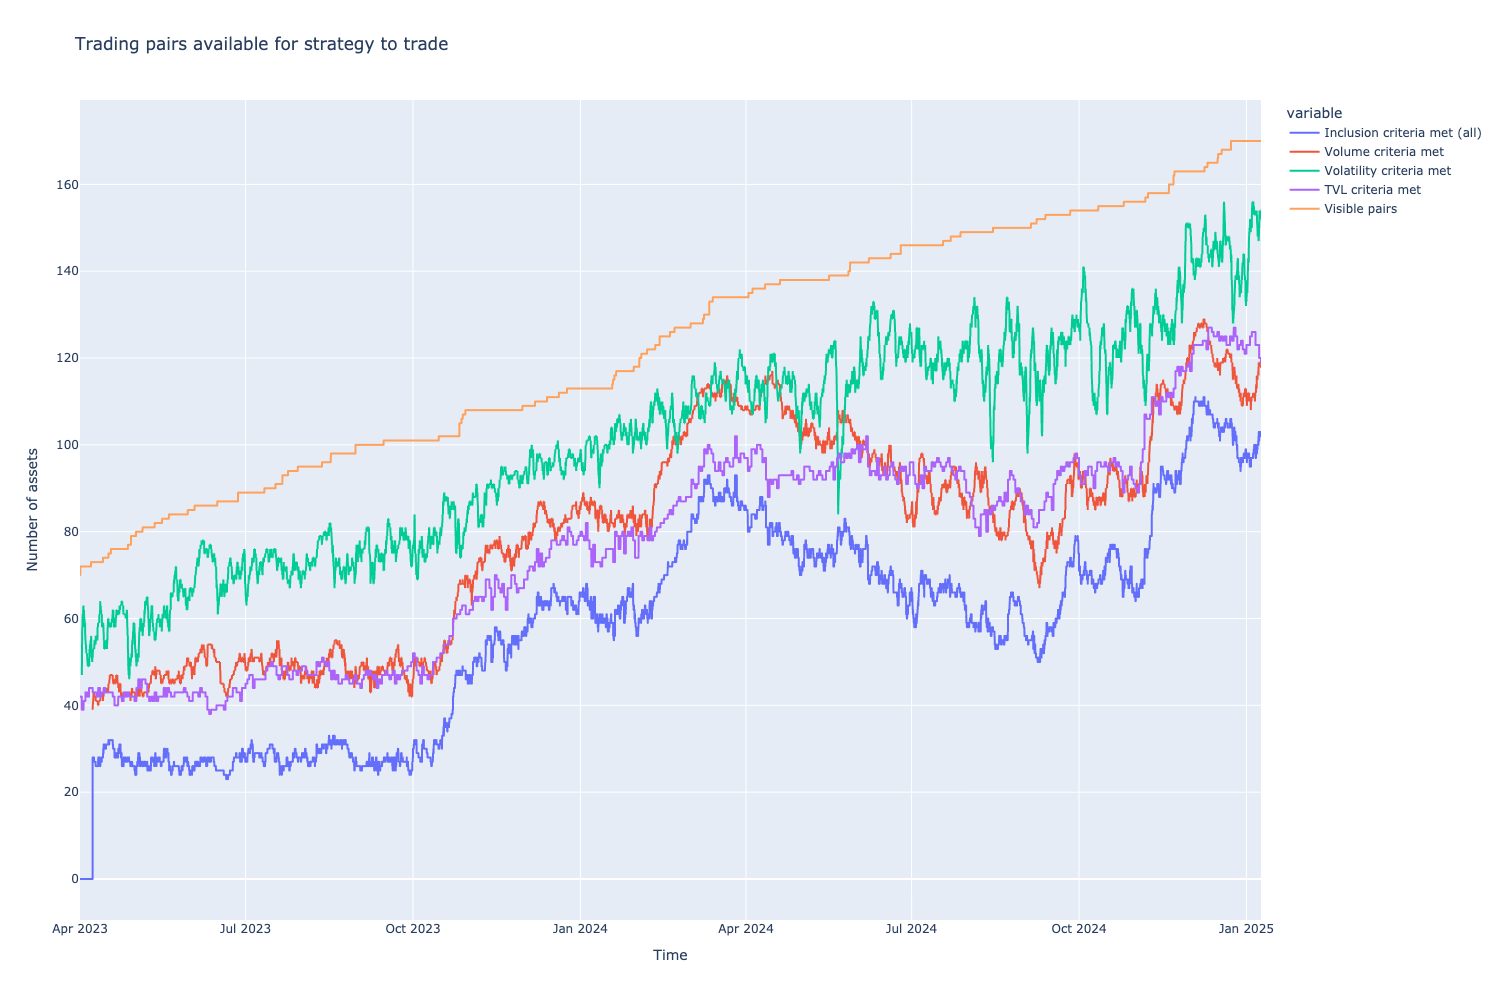

Inclusion criteria met (all)  Volume criteria met  \
2025-01-08 20:00:00                           102                118.0   
2025-01-08 21:00:00                           102                118.0   
2025-01-08 22:00:00                           102                118.0   
2025-01-08 23:00:00                           102                118.0   
2025-01-09 00:00:00                           103                118.0   

                     Volatility criteria met  TVL criteria met  Visible pairs  
2025-01-08 20:00:00                    153.0               120            170  
2025-01-08 21:00:00                    152.0               120            170  
2025-01-08 22:00:00                    152.0               120            170  
2025-01-08 23:00:00                    152.0               120            170  
2025-01-09 00:00:00                    152.0               119            170

In [6]:
import plotly.express as px

df = pd.DataFrame({
    "Inclusion criteria met (all)": indicator_data.get_indicator_series("all_criteria_included_pair_count"),
    "Volume criteria met": indicator_data.get_indicator_series("volume_included_pair_count"),
    "Volatility criteria met": indicator_data.get_indicator_series("volatility_included_pair_count"),
    "TVL criteria met": indicator_data.get_indicator_series("tvl_included_pair_count"),
    "Visible pairs": indicator_data.get_indicator_series("trading_pair_count"),
})

fig = px.line(df, title='Trading pairs available for strategy to trade')
fig.update_yaxes(title="Number of assets")
fig.update_xaxes(title="Time")
fig.show()

display(df.tail(5))

Find the first availability, or admission to index, of all trading pairs.

In [7]:
from tradingstrategy.liquidity import LiquidityDataUnavailable

series = indicator_data.get_indicator_series("inclusion_criteria")

exploded = series.explode()
first_appearance_series = exploded.groupby(exploded.values).apply(lambda x: x.index[0])

df = pd.DataFrame({
    "Included at": first_appearance_series
})

def _get_ticker(pair_id):
    try:
        return strategy_universe.get_pair_by_id(pair_id).get_ticker()
    except Exception:
        return "<pair metadata missing>"

df["Ticker"] = first_appearance_series.index.map(_get_ticker)
df["DEX"] = first_appearance_series.index.map(lambda pair_id: strategy_universe.get_pair_by_id(pair_id).exchange_name)
df = df.sort_values("Included at")

def _map_tvl(row):
    pair_id = row.name  # Indxe
    timestamp = row["Included at"]
    try:
        tvl, delay = strategy_universe.data_universe.liquidity.get_liquidity_with_tolerance(
            pair_id,
            timestamp,
            tolerance=pd.Timedelta(days=2),
        )
        return tvl
    except LiquidityDataUnavailable:
        # TODO Data dates mismatch?
        return 0 

# Get the first entry and value of rolling cum volume of each pair
volume_series = indicator_data.get_indicator_data_pairs_combined("rolling_cumulative_volume")
first_volume_df = volume_series.reset_index().groupby("pair_id").first()

def _map_volume_timestamp(row):
    pair_id = row.name  # Index
    try:
        return first_volume_df.loc[pair_id]["timestamp"]
    except KeyError:
        return None
    
def _map_volume_value(row):
    pair_id = row.name  # Index
    try:
        return first_volume_df.loc[pair_id]["value"]
    except KeyError:
        return None

df["TVL at inclusion"] = df.apply(_map_tvl, axis=1)
df["Rolling volume first entry at"] = df.apply(_map_volume_timestamp, axis=1)
df["Rolling volume initial"] = df.apply(_map_volume_value, axis=1)

print(f"First appearances of {len(df)} trading pairs, when they meet all inclusion criteria:")

with pd.option_context("display.float_format", "{:,.2f}".format):
    display(df)


First appearances of 160 trading pairs, when they meet all inclusion criteria:


Included at          Ticker         DEX  TVL at inclusion  \
2749791 2023-04-07 23:00:00        XEN-WETH  uniswap-v3      1,374,711.38   
2701863 2023-04-07 23:00:00        GNO-WETH  uniswap-v3      9,681,509.47   
2701707 2023-04-07 23:00:00        BIT-WETH  uniswap-v3     25,459,356.57   
2699631 2023-04-07 23:00:00        FTM-WETH  uniswap-v3      1,170,413.51   
2711765 2023-04-07 23:00:00        IMX-WETH  uniswap-v3      1,127,978.37   
2699186 2023-04-07 23:00:00       AGIX-WETH  uniswap-v3      3,501,048.79   
2698994 2023-04-07 23:00:00        LDO-WETH  uniswap-v3     12,653,120.65   
2711819 2023-04-07 23:00:00        ENS-WETH  uniswap-v3      2,618,719.92   
2698484 2023-04-07 23:00:00      Metis-WETH  uniswap-v3      1,521,744.12   
2697712 2023-04-07 23:00:00      MATIC-WETH  uniswap-v3      8,657,503.59   
2711866 2023-04-07 23:00:00        RPL-WETH  uniswap-v3      1,133,683.86   
2697610 2023-04-07 23:00:00       LINK-WETH  uniswap-v3     10,447,265.73   
2697609 2023-04-07 23:00:00       AAVE-WETH  uniswap-v3      1,085,586.11   
2697602 2023-04-07 23:00:00        MKR-WETH  uniswap-v3      1,560,309.88   
2697591 2023-04-07 23:00:00       LQTY-WETH  uniswap-v3      3,668,365.98   
2697583 2023-04-07 23:00:00        UNI-WETH  uniswap-v3     10,272,023.93   
2697689 2023-04-07 23:00:00        CRV-WETH  uniswap-v3      1,179,371.45   
68900   2023-04-07 23:00:00      FLOKI-WETH  uniswap-v2      5,933,709.25   
61381   2023-04-07 23:00:00         MC-WETH  uniswap-v2     13,088,520.63   
59188   2023-04-07 23:00:00      BOTTO-WETH  uniswap-v2      2,619,711.88   
51724   2023-04-07 23:00:00      STARL-WETH  uniswap-v2      3,683,899.36   
33873   2023-04-07 23:00:00      SUPER-WETH  uniswap-v2      6,309,481.18   
50635   2023-04-07 23:00:00        UFO-WETH  uniswap-v2      4,939,400.15   
37316   2023-04-07 23:00:00       ELON-WETH  uniswap-v2     13,645,703.88   
523     2023-04-07 23:00:00       PAXG-WETH  uniswap-v2      8,002,858.09   
78008   2023-04-07 23:00:00        CAW-WETH  uniswap-v2     11,504,907.95   
21431   2023-04-07 23:00:00        WOO-WETH  uniswap-v2      4,534,887.21   
2921607 2023-04-07 23:00:00       BLUR-WETH  uniswap-v3      1,528,608.36   
40233   2023-04-08 00:00:00       WILD-WETH  uniswap-v2      2,833,702.01   
34469   2023-04-08 01:00:00        ERN-WETH  uniswap-v2      4,334,741.60   
2699978 2023-04-08 08:00:00       INST-WETH  uniswap-v3      2,272,769.34   
2697999 2023-04-10 00:00:00       RNDR-WETH  uniswap-v3      1,413,940.16   
29845   2023-04-12 05:00:00       WISE-WETH  uniswap-v2    130,533,686.84   
2697863 2023-04-13 19:00:00       PERP-WETH  uniswap-v3      1,656,102.88   
3001712 2023-04-14 00:00:00        GLM-WETH  uniswap-v3      1,001,278.58   
2896934 2023-04-14 00:00:00        0x0-WETH  uniswap-v2      1,074,719.09   
50980   2023-04-15 07:00:00       DEXT-WETH  uniswap-v2      3,712,472.78   
2697728 2023-04-17 00:00:00        GRT-WETH  uniswap-v3      1,062,943.78   
2702046 2023-04-17 00:00:00       DYDX-WETH  uniswap-v3      1,020,916.48   
2700236 2023-04-22 15:00:00       VITA-WETH  uniswap-v3      1,664,238.76   
3010484 2023-04-23 15:00:00       PEPE-WETH  uniswap-v2      3,388,108.76   
3015124 2023-04-30 00:00:00      WOJAK-WETH  uniswap-v2      1,070,989.74   
3034869 2023-05-04 07:00:00        RBX-WETH  uniswap-v3      1,170,045.79   
3038307 2023-05-06 00:00:00   pepecoin-WETH  uniswap-v2      1,017,782.22   
3044332 2023-05-08 18:00:00      TURBO-WETH  uniswap-v3      2,177,515.87   
2697715 2023-05-21 11:00:00        OVR-WETH  uniswap-v3      2,806,311.04   
3097156 2023-05-26 20:00:00        RFD-WETH  uniswap-v3     11,847,048.82   
3126522 2023-06-06 04:00:00         OX-WETH  uniswap-v3      3,447,521.78   
3136008 2023-06-09 23:00:00       WPLS-WETH  uniswap-v3      3,643,407.48   
3036567 2023-06-21 00:00:00      swETH-WETH  uniswap-v3      1,042,834.39   
3155848 2023-06-22 10:00:00     UNIBOT-WETH  uniswap-v2      1,948,071.31   
3200850 2023

# Signal across pairs

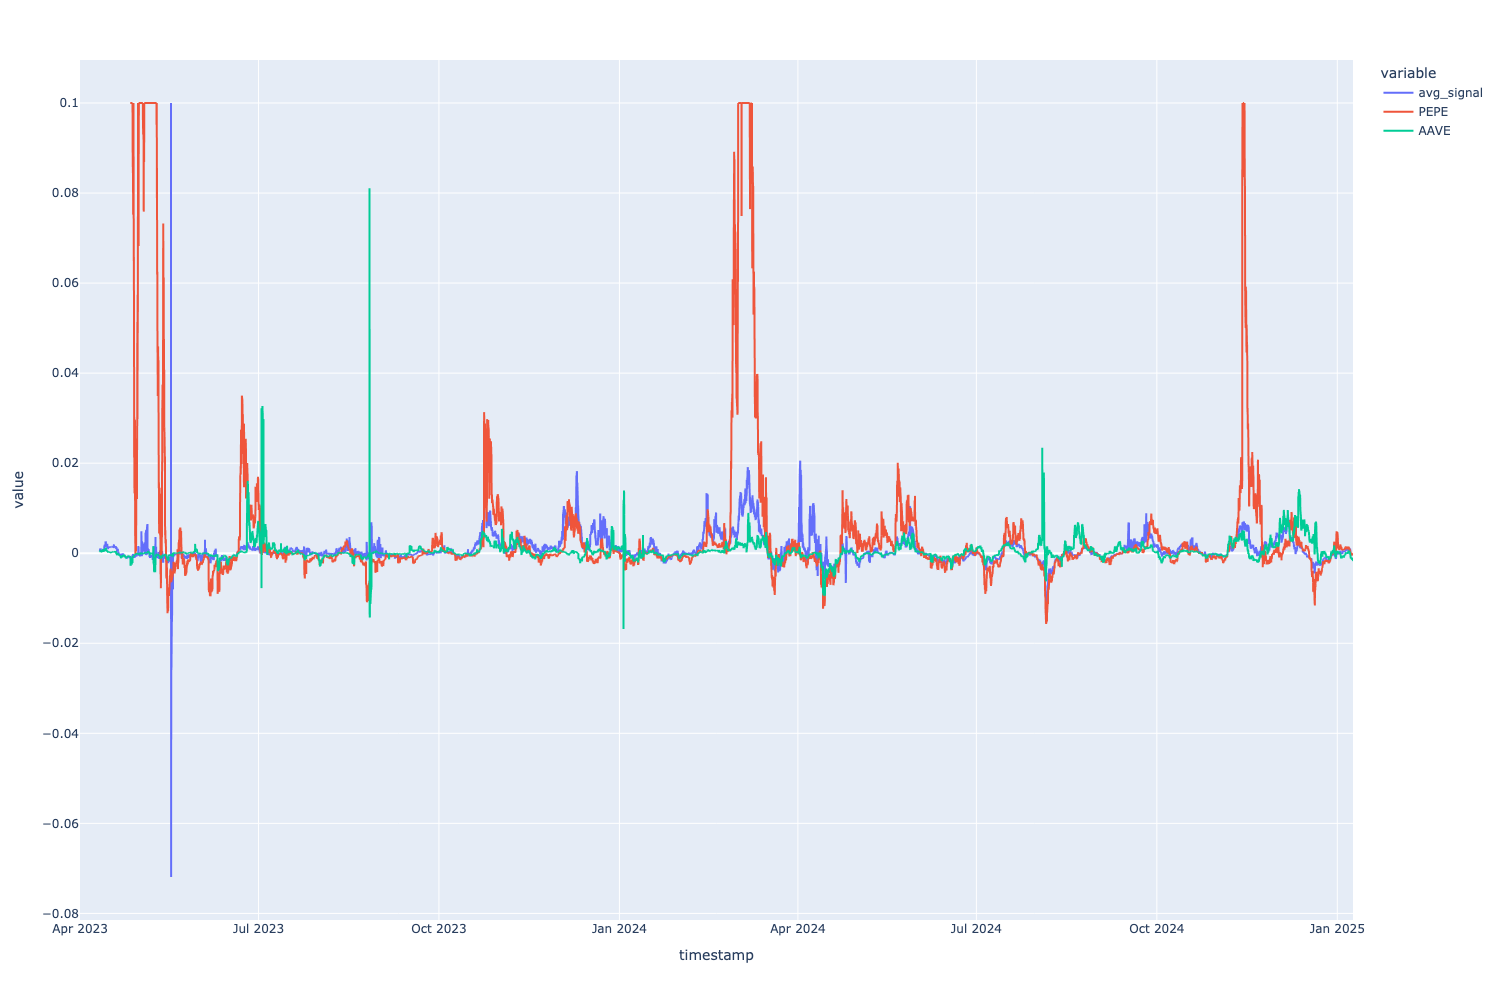

In [8]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

selected_assets = EXAMINED_ASSETS[0:2]

# max_displayed_vol = avg_signal.max() * 1.1
upper_displayed = 0.1

avg_signal = indicator_data.get_indicator_series("avg_signal")

data = {
    "avg_signal": avg_signal.clip(upper=upper_displayed),
}


# TODO: Plotly refuses correctly to plot the third y-axis
for symbol in selected_assets:
    pair = token_map[symbol]
    signal = indicator_data.get_indicator_series("volatility_returns_indicator", pair=pair)
    signal = signal.clip(upper=upper_displayed)
    data[symbol] = signal
    
df = pd.DataFrame(data)
fig = px.line(df)
fig.show()


# Volatility across pairs

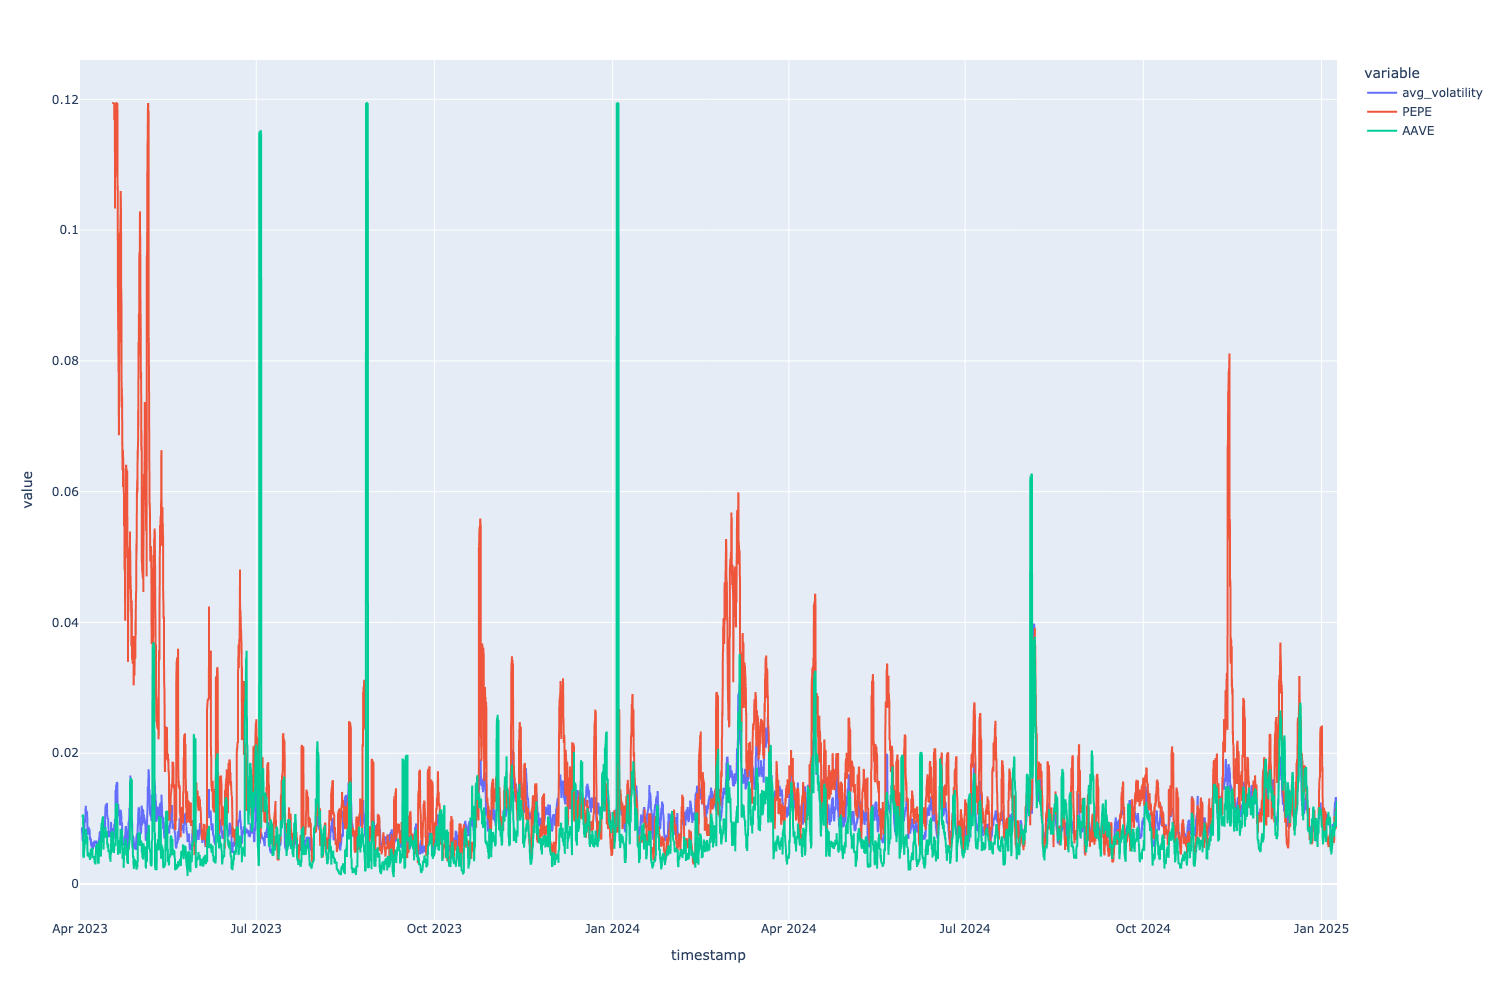

In [9]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

selected_assets = EXAMINED_ASSETS[0:2]

avg_volatility = indicator_data.get_indicator_series("avg_volatility")

volatilities = {
    "avg_volatility": avg_volatility,
}

max_displayed_vol = avg_volatility.max() * 3

# TODO: Plotly refuses correctly to plot the third y-axis
for symbol in selected_assets:
    pair = token_map[symbol]
    volatility = indicator_data.get_indicator_series("volatility", pair=pair)
    volatility = volatility.clip(upper=max_displayed_vol)
    volatilities[symbol] = volatility
    
volatility_df = pd.DataFrame(volatilities)
fig = px.line(volatility_df)
fig.show()


# Price vs. signal

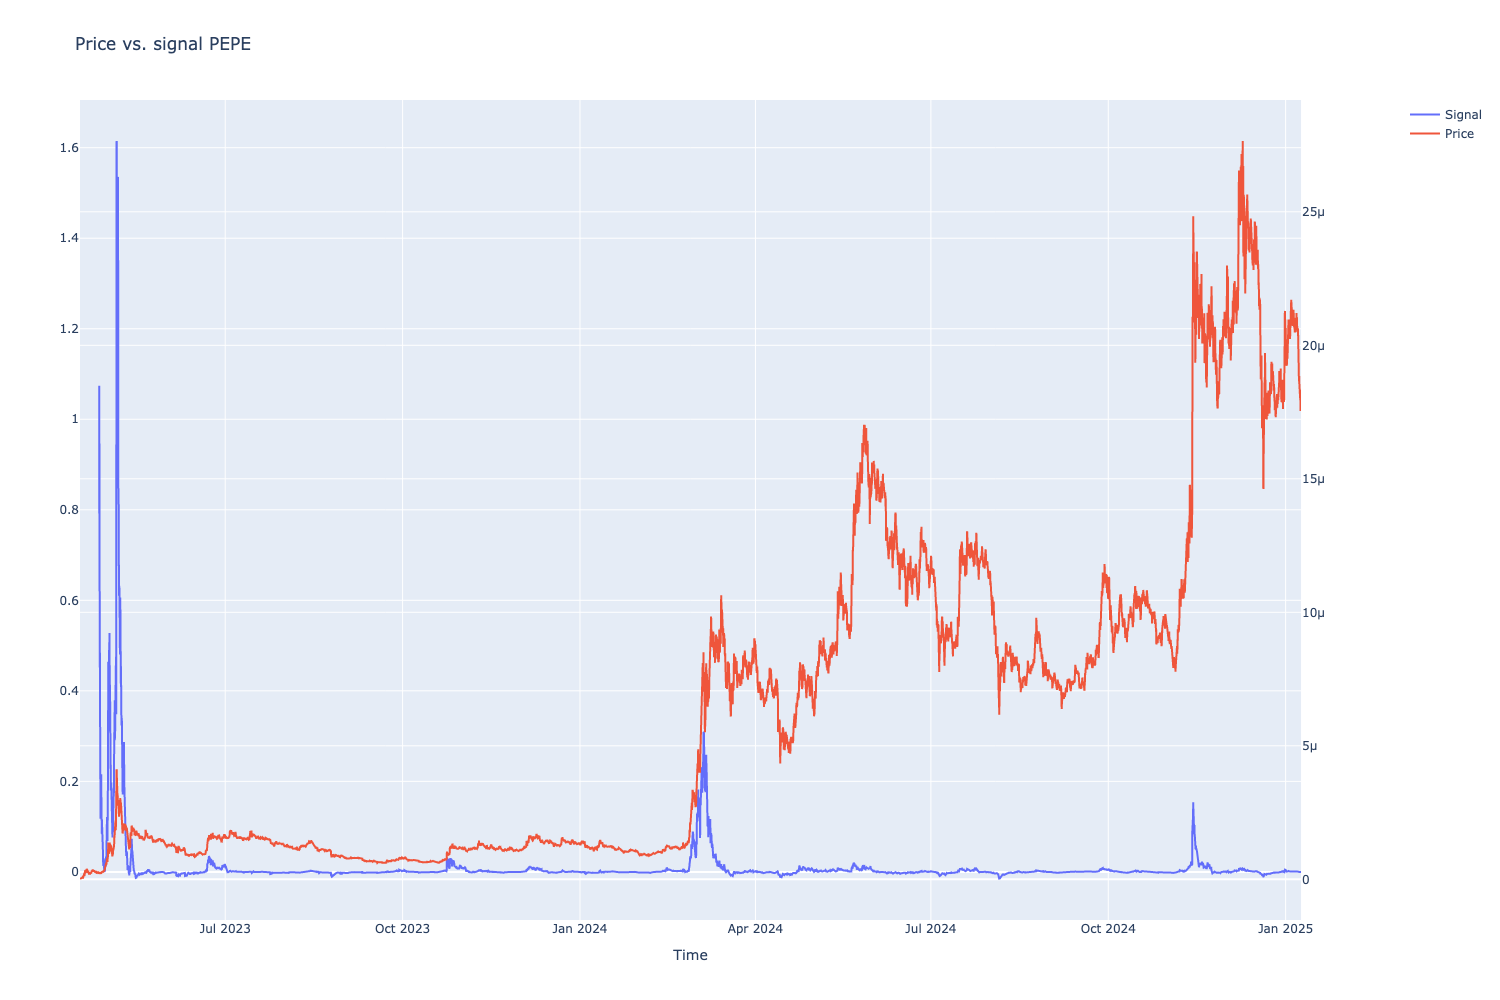

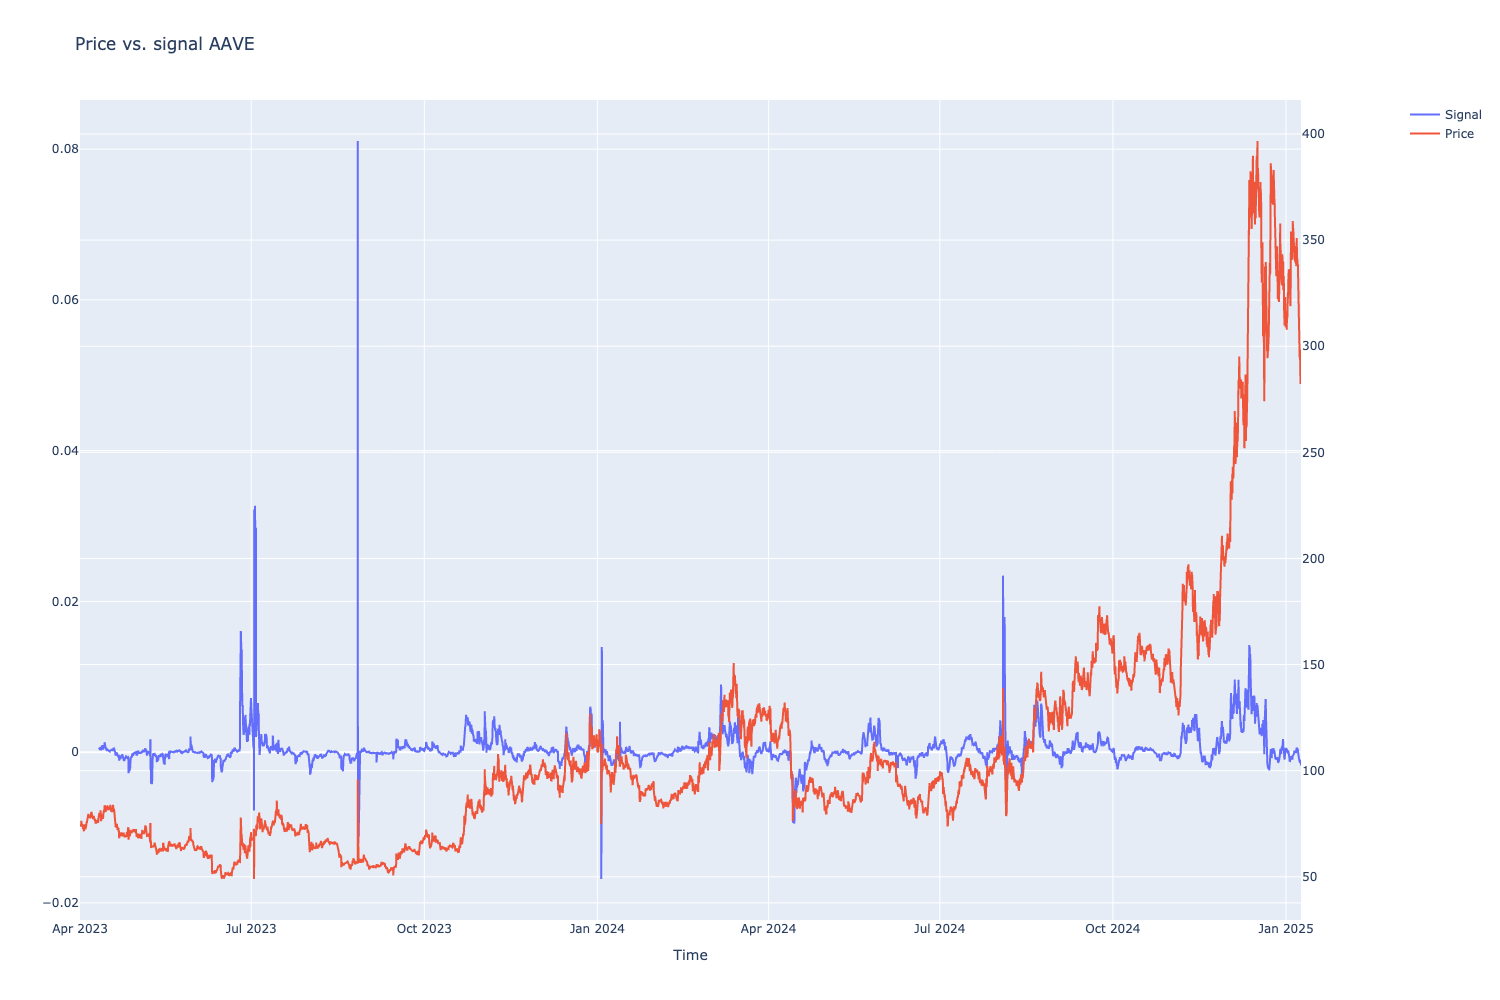

In [10]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

selected_assets = EXAMINED_ASSETS[0:2]

# TODO: Plotly refuses correctly to plot the third y-axis
for symbol in selected_assets:
    pair = token_map[symbol]
    price = strategy_universe.data_universe.candles.get_candles_by_pair(pair.internal_id)["close"]
    signal = indicator_data.get_indicator_series("volatility_returns_indicator", pair=pair)    
    volatility = indicator_data.get_indicator_series("volatility", pair=pair)

    df = pd.DataFrame({
        "price": price,
        "signal": signal,
        # "volatility": volatility,
    })

    fig = make_subplots(specs=[[{"secondary_y": True}]])

    fig.add_trace(
        go.Scatter(x=df.index, y=df["signal"], name="Signal"),
        secondary_y=False,        
    )

    # fig.add_trace(
    #    go.Scatter(x=df.index, y=df["volatility"], name="Volatility", yaxis="y2"),
    #    secondary_y=True,
    #)

    fig.add_trace(
        go.Scatter(x=df.index, y=df["price"], name="Price", yaxis="y3"),
        secondary_y=True,        
    )

    fig.update_layout(title=f"Price vs. signal {symbol}")
    fig.update_layout(showlegend=True)
    fig.update_xaxes(title="Time")
    # fig.update_layout(
    #    yaxis_type="log"   
    #)
    

    fig.show()
    

# Price vs. volatility

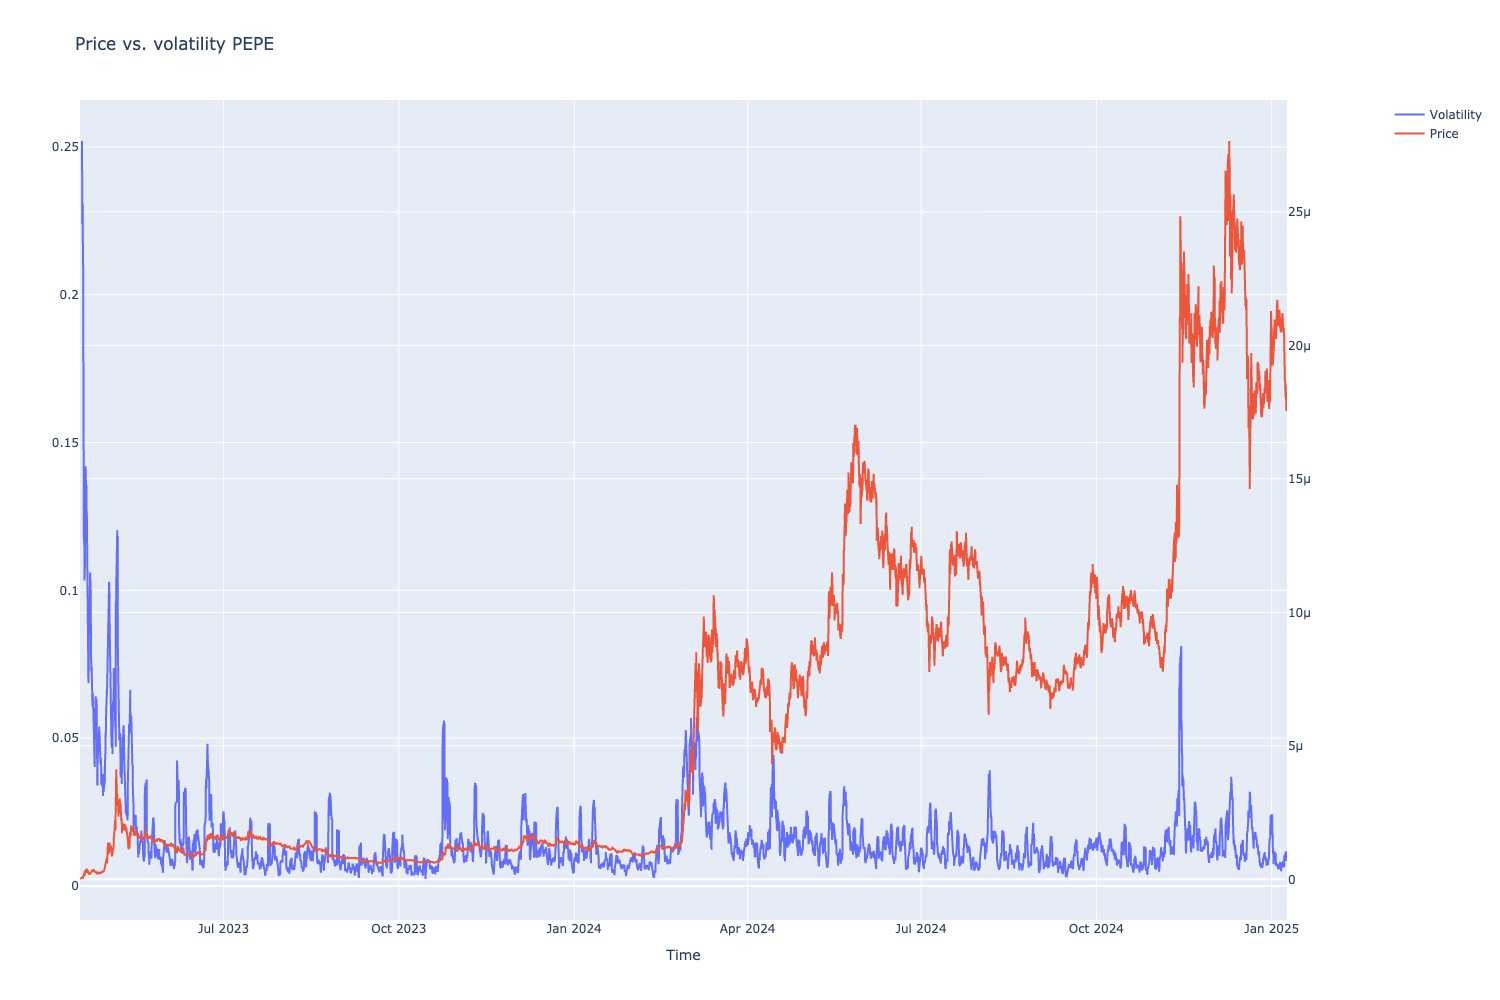

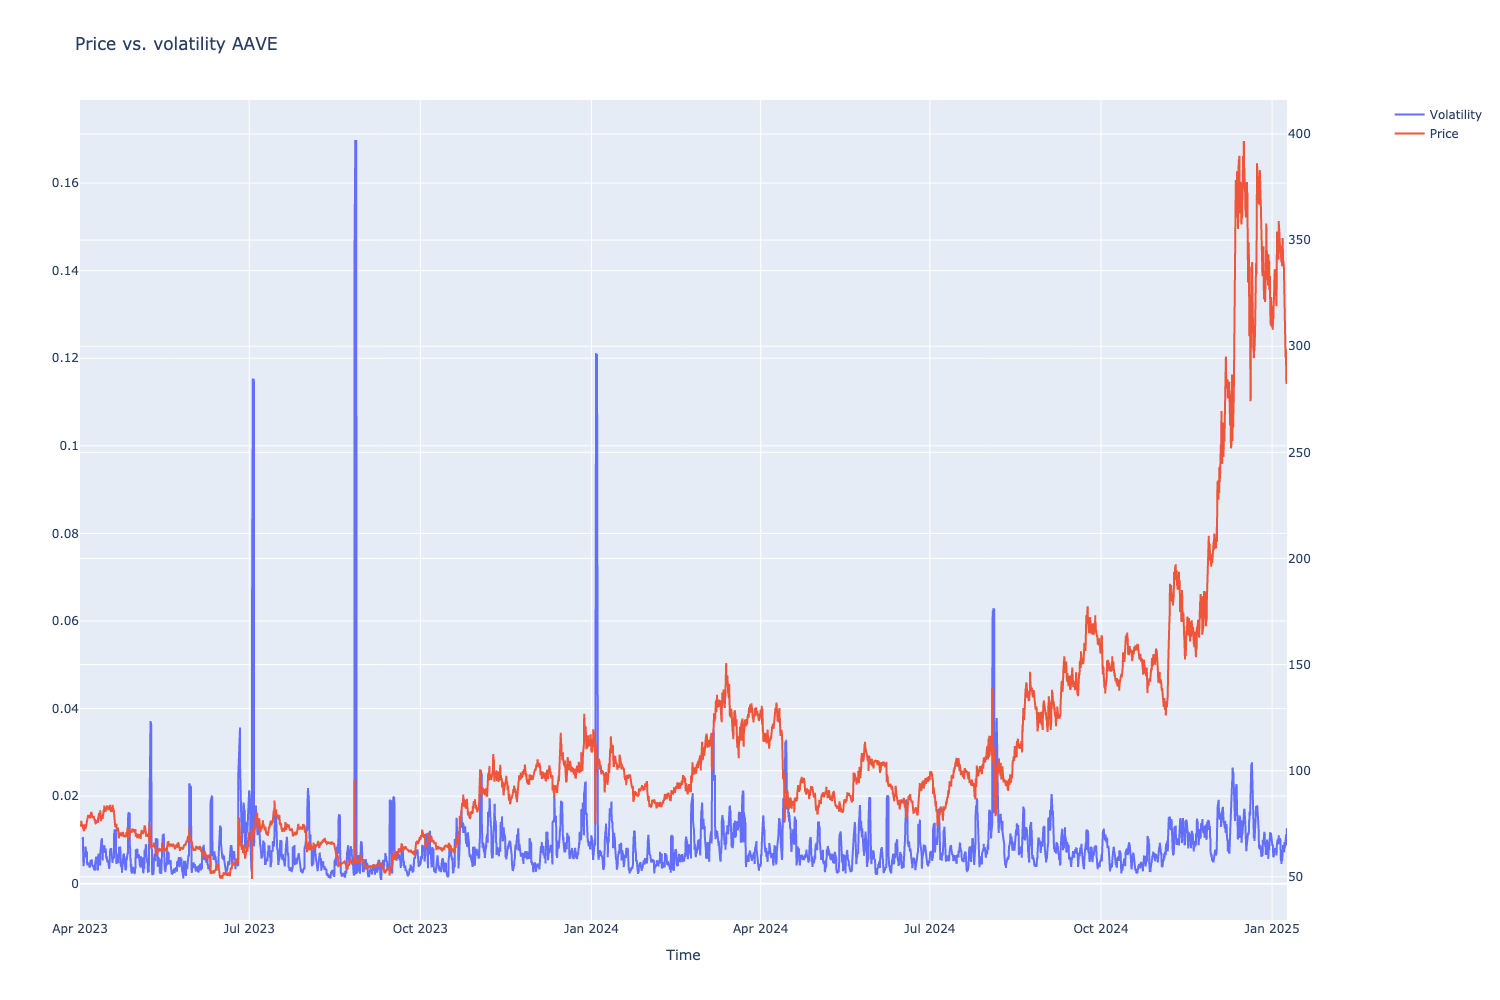

In [11]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

selected_assets = EXAMINED_ASSETS[0:2]

# TODO: Plotly refuses correctly to plot the third y-axis
for symbol in selected_assets:
    pair = token_map[symbol]
    price = strategy_universe.data_universe.candles.get_candles_by_pair(pair.internal_id)["close"]
    signal = indicator_data.get_indicator_series("volatility_returns_indicator", pair=pair)    
    volatility = indicator_data.get_indicator_series("volatility", pair=pair)

    df = pd.DataFrame({
        "price": price,
        "signal": signal,
        "volatility": volatility,
    })

    fig = make_subplots(specs=[[{"secondary_y": True}]])

    fig.add_trace(
        go.Scatter(x=df.index, y=df["volatility"], name="Volatility"),
        secondary_y=False,        
    )

    # fig.add_trace(
    #    go.Scatter(x=df.index, y=df["volatility"], name="Volatility", yaxis="y2"),
    #    secondary_y=True,
    #)

    fig.add_trace(
        go.Scatter(x=df.index, y=df["price"], name="Price", yaxis="y3"),
        secondary_y=True,        
    )

    fig.update_layout(title=f"Price vs. volatility {symbol}")
    fig.update_layout(showlegend=True)
    fig.update_xaxes(title="Time")
    # fig.update_layout(
    #    yaxis_type="log"   
    #)
    

    fig.show()
    

# Backtest time range

- Choose the backtesting time range
- Start when we have enough assets (`Parameters.min_asset_universe`) in our asset universe to form the first basket

In [12]:
series = indicator_data.get_indicator_series("all_criteria_included_pair_count")

exceeds_threshold = series > Parameters.min_asset_universe
# Get the first date where the condition is True
backtest_start = Parameters.backtest_start
backtest_end = Parameters.backtest_end

print(f"Time range is {backtest_start} - {backtest_end}")

Time range is 2023-04-01 00:00:00 - 2025-01-09 00:00:00


# Strategy algorithm and backtest

- Run the backtest

In [13]:
from tradeexecutor.backtest.backtest_runner import run_backtest_inline
from tradeexecutor.strategy.alpha_model import AlphaModel
from tradeexecutor.state.trade import TradeExecution
from tradeexecutor.strategy.pandas_trader.strategy_input import StrategyInput, IndicatorDataNotFoundWithinDataTolerance
from tradeexecutor.state.visualisation import PlotKind
from tradeexecutor.backtest.backtest_runner import run_backtest_inline
from tradeexecutor.strategy.tvl_size_risk import USDTVLSizeRiskModel
from tradeexecutor.strategy.weighting import weight_by_1_slash_n, weight_passthrouh, weight_equal
from tradeexecutor.utils.dedent import dedent_any


def decide_trades(
    input: StrategyInput
) -> list[TradeExecution]:
    """For each strategy tick, generate the list of trades."""
    parameters = input.parameters
    position_manager = input.get_position_manager()
    state = input.state
    timestamp = input.timestamp
    indicators = input.indicators
    strategy_universe = input.strategy_universe

    # Build signals for each pair 
    alpha_model = AlphaModel(
        timestamp,
        close_position_weight_epsilon=parameters.min_portfolio_weight,  # 10 BPS is our min portfolio weight
    )

    # Prepare diagnostics variables
    max_vol = (0, None)  
    signal_count = 0  
    vol_pair = strategy_universe.get_pair_by_human_description(VOL_PAIR)
    volume_included_pair_count = indicators.get_indicator_value(
        "volume_included_pair_count",
    )
    volatility_included_pair_count = indicators.get_indicator_value(
        "volatility_included_pair_count",
    ) 
    tvl_included_pair_count = indicators.get_indicator_value(
        "tvl_included_pair_count",
    )
    
    # Get pairs included in this rebalance cycle.
    # This includes pair that have been pre-cleared in inclusion_criteria()
    # with volume, volatility and TVL filters 
    included_pairs = indicators.get_indicator_value(
        "inclusion_criteria",
        na_conversion=False,
    )
    if included_pairs is None:
        included_pairs = []

    clipped_pairs = 0

    avg_signal = indicators.get_indicator_value("avg_signal")
    if avg_signal is None:
        return []

    # Set signal for each pair
    for pair_id in included_pairs:
        pair = strategy_universe.get_pair_by_id(pair_id)

        pair_signal = indicators.get_indicator_value("volatility_returns_indicator", pair=pair)
        if pair_signal is None:
            continue

        weight = pair_signal - parameters.min_signal_threshold

        if weight < 0:
            continue
    
        alpha_model.set_signal(
            pair,
            weight,
        )

        # Diagnostics reporting
        signal_count += 1


    # Calculate how much dollar value we want each individual position to be on this strategy cycle,
    # based on our total available equity
    portfolio = position_manager.get_current_portfolio()
    portfolio_target_value = portfolio.get_total_equity() * parameters.allocation

    # Select max_assets_in_portfolio assets in which we are going to invest
    # Calculate a weight for ecah asset in the portfolio using 1/N method based on the raw signal
    alpha_model.select_top_signals(count=parameters.max_assets_in_portfolio)
    alpha_model.assign_weights(method=weight_passthrouh)
    # alpha_model.assign_weights(method=weight_by_1_slash_n)

    #
    # Normalise weights and cap the positions
    # 
    size_risk_model = USDTVLSizeRiskModel(
        pricing_model=input.pricing_model,
        per_position_cap=parameters.per_position_cap_of_pool,  # This is how much % by all pool TVL we can allocate for a position
        missing_tvl_placeholder_usd=parameters.assummed_liquidity_when_data_missings,  # Placeholder for missing TVL data until we get the data off the chain
    )

    alpha_model.normalise_weights(
        investable_equity=portfolio_target_value,
        size_risk_model=size_risk_model,
        max_weight=parameters.max_concentration,
    )

    # Load in old weight for each trading pair signal,
    # so we can calculate the adjustment trade size
    alpha_model.update_old_weights(
        state.portfolio,
        ignore_credit=True,
    )
    alpha_model.calculate_target_positions(position_manager)

    # Shift portfolio from current positions to target positions
    # determined by the alpha signals (momentum)
    
    # rebalance_threshold_usd = portfolio_target_value * parameters.min_rebalance_trade_threshold_pct
    rebalance_threshold_usd = parameters.individual_rebalance_min_threshold_usd
    
    assert rebalance_threshold_usd > 0.1, "Safety check tripped - something like wrong with strat code"
    trades = alpha_model.generate_rebalance_trades_and_triggers(
        position_manager,
        min_trade_threshold=rebalance_threshold_usd,  # Don't bother with trades under XXXX USD
        invidiual_rebalance_min_threshold=parameters.individual_rebalance_min_threshold_usd,
        execution_context=input.execution_context,
    )

    # Supply or withdraw cash to Aave if strategy is set to do so
    if parameters.use_aave:
        credit_deposit_flow = position_manager.calculate_credit_flow_needed(
            trades,
            parameters.allocation,
        )
        credit_flow_dust_threshold = 3.0  # Min deposit USD to Aave
        if credit_deposit_flow > credit_flow_dust_threshold:
            trades += position_manager.manage_credit_flow(credit_deposit_flow)
    else:
        credit_deposit_flow = 0

    # Add verbal report about decision made/not made,
    # so it is much easier to diagnose live trade execution.
    # This will be readable in Discord/Telegram logging.
    if input.is_visualisation_enabled():
        try:
            top_signal = next(iter(alpha_model.get_signals_sorted_by_weight()))
            if top_signal.normalised_weight == 0:
                top_signal = None
        except StopIteration:
            top_signal = None

        max_vol_pair = max_vol[1]
        if max_vol_pair:
            max_vol_signal = alpha_model.get_signal_by_pair(max_vol_pair)
        else:
            max_vol_signal = None

        vol_pair_vol = indicators.get_indicator_value("volatility_ewm", pair=vol_pair)

        rebalance_volume = sum(t.get_value() for t in trades)
        
        report = dedent_any(f"""
        Cycle: #{input.cycle}
        Rebalanced: {'👍' if alpha_model.is_rebalance_triggered() else '👎'}
        Open/about to open positions: {len(state.portfolio.open_positions)} 
        Max position value change: {alpha_model.max_position_adjust_usd:,.2f} USD
        Rebalance threshold: {alpha_model.position_adjust_threshold_usd:,.2f} USD
        Trades decided: {len(trades)}
        Pairs total: {strategy_universe.data_universe.pairs.get_count()}
        Pairs meeting inclusion criteria: {len(included_pairs)}
        Pairs meeting volume inclusion criteria: {volume_included_pair_count}
        Pairs meeting volatility inclusion criteria: {volatility_included_pair_count}        
        Pairs meeting TVL inclusion criteria: {tvl_included_pair_count}        
        Pairs under volatility threshold: {clipped_pairs}        
        Signals created: {signal_count}
        Total equity: {portfolio.get_total_equity():,.2f} USD
        Cash: {position_manager.get_current_cash():,.2f} USD
        Investable equity: {alpha_model.investable_equity:,.2f} USD
        Accepted investable equity: {alpha_model.accepted_investable_equity:,.2f} USD
        Allocated to signals: {alpha_model.get_allocated_value():,.2f} USD
        Discarted allocation because of lack of lit liquidity: {alpha_model.size_risk_discarded_value:,.2f} USD
        Credit deposit flow: {credit_deposit_flow:,.2f} USD
        Rebalance volume: {rebalance_volume:,.2f} USD
        {vol_pair.base.token_symbol} volatility: {vol_pair_vol}        
        Most volatility pair: {max_vol_pair.get_ticker() if max_vol_pair else '-'}
        Most volatility pair vol: {max_vol[0]}
        Most volatility pair signal value: {max_vol_signal.signal if max_vol_signal else '-'}
        Most volatility pair signal weight: {max_vol_signal.raw_weight if max_vol_signal else '-'}        
        """)

        # Most volatility pair signal weight (normalised): {max_vol_signal.normalised_weight * 100 if max_vol_signal else '-'} % (got {max_vol_signal.position_size_risk.get_relative_capped_amount() * 100 if max_vol_signal else '-'} % of asked size)
        if top_signal:
            top_signal_vol = indicators.get_indicator_value("volatility_ewm", pair=top_signal.pair)
            assert top_signal.position_size_risk
            report += dedent_any(f"""
            Top signal pair: {top_signal.pair.get_ticker()}
            Top signal volatility: {top_signal_vol}
            Top signal value: {top_signal.signal}
            Top signal weight: {top_signal.raw_weight}
            Top signal weight (normalised): {top_signal.normalised_weight * 100:.2f} % (got {top_signal.position_size_risk.get_relative_capped_amount() * 100:.2f} % of asked size)
            """)            

        for flag, count in alpha_model.get_flag_diagnostics_data().items():
            report += f"Signals with flag {flag.name}: {count}\n"

        state.visualisation.add_message(
            timestamp,
            report, 
        )

        state.visualisation.set_discardable_data("alpha_model", alpha_model)
    
    return trades  # Return the list of trades we made in this cycle


result = run_backtest_inline(
    name=parameters.id,
    engine_version="0.5",
    decide_trades=decide_trades,
    create_indicators=indicators.create_indicators,
    client=client,
    universe=strategy_universe,
    parameters=parameters,
    # log_level=logging.INFO,
    max_workers=1,
    start_at=backtest_start,
    end_at=backtest_end,
)

state = result.state

trade_count = len(list(state.portfolio.get_all_trades()))
print(f"Backtesting completed, backtested strategy made {trade_count} trades")

Reading cached indicators trailing_sharpe, trailing_sharpe_ewm, volatility, signed_volatility, rolling_returns…

Using indicator cache /Users/moo/.cache/indicators/ethereum_1h_172_2023-04-01-2025-01-09_ff


  0%|          | 0/56073600 [00:00<?, ?it/s]

Backtesting completed, backtested strategy made 4052 trades


# Performance metrics

- Display portfolio performance metrics
- Compare against buy and hold matic using the same initial capital

**Note**: Some of these metrics might be incorrect due to slow start of the strategy

In [14]:
from tradeexecutor.analysis.multi_asset_benchmark import compare_strategy_backtest_to_multiple_assets

compare_strategy_backtest_to_multiple_assets(
    state,
    strategy_universe,
    display=True,
    interesting_assets=EXAMINED_ASSETS,
    asset_count=6,
)

Strategy                 PEPE  \
Start Period                        2023-04-01           2023-04-01   
End Period                          2025-01-08           2025-01-08   
Risk-Free Rate                            0.0%                 0.0%   
Time in Market                           58.0%                98.0%   
Cumulative Return                      600.79%           98,483.57%   
CAGR﹪                                  113.23%             1359.68%   
Sharpe                                    1.86                 2.13   
Prob. Sharpe Ratio                      99.88%               100.0%   
Smart Sharpe                              1.58                 1.81   
Sortino                                   4.09                 7.32   
Smart Sortino                             3.48                 6.22   
Sortino/√2                                2.89                 5.18   
Smart Sortino/√2                          2.46                  4.4   
Omega                                     1.69                 1.69   
Max Drawdown                           -33.48%              -82.69%   
Longest DD Days                            222                  300   
Volatility (ann.)                       71.42%              322.78%   
Calmar                                    3.38                16.44   
Skew                                      4.52                10.73   
Kurtosis                                 46.79               178.59   
Expected Daily                            0.3%                1.07%   
Expected Monthly                         9.25%                36.8%   
Expected Yearly                         91.36%              895.26%   
Kelly Criterion                         18.32%               23.49%   
Risk of Ruin                              0.0%                 0.0%   
Daily Value-at-Risk                     -5.78%              -25.91%   
Expected Shortfall (cVaR)               -5.78%              -25.91%   
Max Consecutive Wins                         4                    6   
Max Consecutive Losses                       7                    7   
Gain/Pain Ratio                           0.69                 0.75   
Gain/Pain (1M)                            6.71                 7.98   
Payoff Ratio                              2.08                 1.84   
Profit Factor                             1.69                 1.75   
Common Sense Ratio                        2.33                 2.48   
CPC Index                                 1.58                 1.62   
Tail Ratio                                1.38                 1.42   
Outlier Win Ratio                        11.35                 4.41   
Outlier Loss Ratio                        4.13                  2.5   
MTD                                     -1.81%                3.74%   
3M                                      15.41%               79.81%   
6M                                      43.82%                95.9%   
YTD                                     -1.81%                3.74%   
1Y                                     210.16%             1510.15%   
3Y (ann.)                              113.23%             1359.68%   
5Y (ann.)                              113.23%             1359.68%   
10Y (ann.)                             113.23%             1359.68%   
All-time (ann.)                        113.23%             1359.68%   
Best Day                                45.15%              311.19%   
Worst Day                              -19.75%              -33.49%   
Best Month                               67.3%             2371.74%   
Worst Month                             -8.72%              -34.67%   
Best Year                              203.36%             6840.96%   
Worst Year                              -1.81%                3.74%   
Avg. Drawdown                           -6.26%              -24.96%   
Avg. Drawdown Days                          23                   40   
Recovery Factor                           7.06                

# Equity curve

- Equity curve shows how your strategy accrues value over time

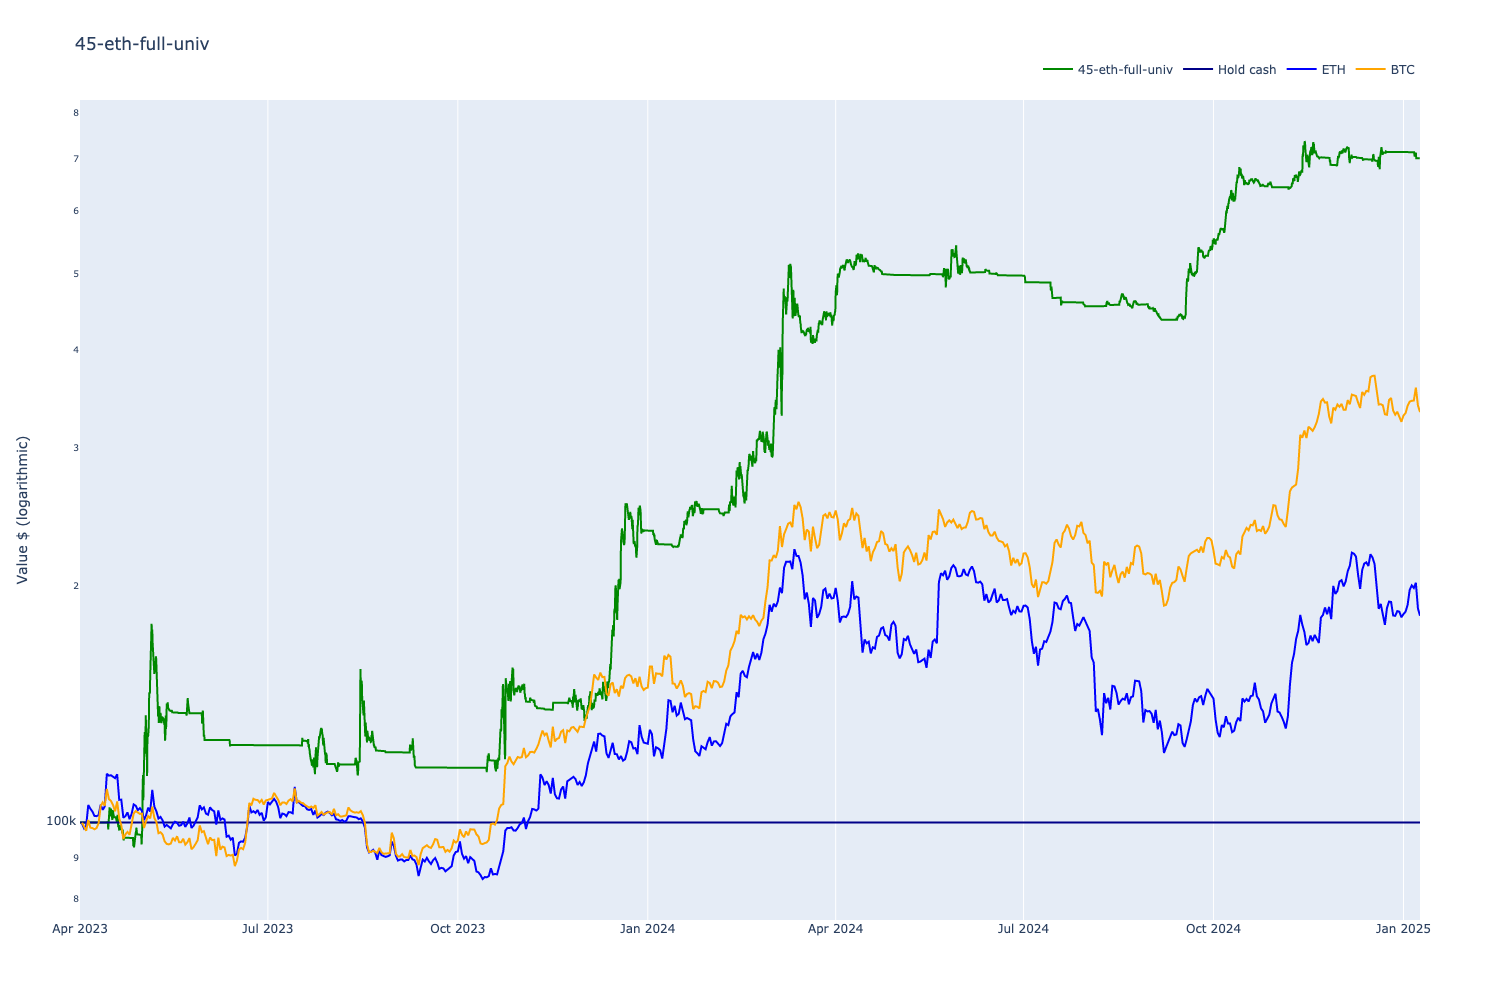

In [15]:
import pandas as pd
from tradeexecutor.analysis.multi_asset_benchmark import get_benchmark_data
from tradeexecutor.visual.benchmark import visualise_equity_curve_benchmark

benchmark_indexes = get_benchmark_data(
    strategy_universe,
    cumulative_with_initial_cash=state.portfolio.get_initial_cash(),
    max_count=4,
    start_at=state.get_trading_time_range()[0],
    interesting_assets=["WETH", "WBTC"],
)

fig = visualise_equity_curve_benchmark(
    state=state,    
    benchmark_indexes=benchmark_indexes,
    height=800,
    log_y=True,
)

fig.show()

## Equity curve with drawdown

- Linear curve

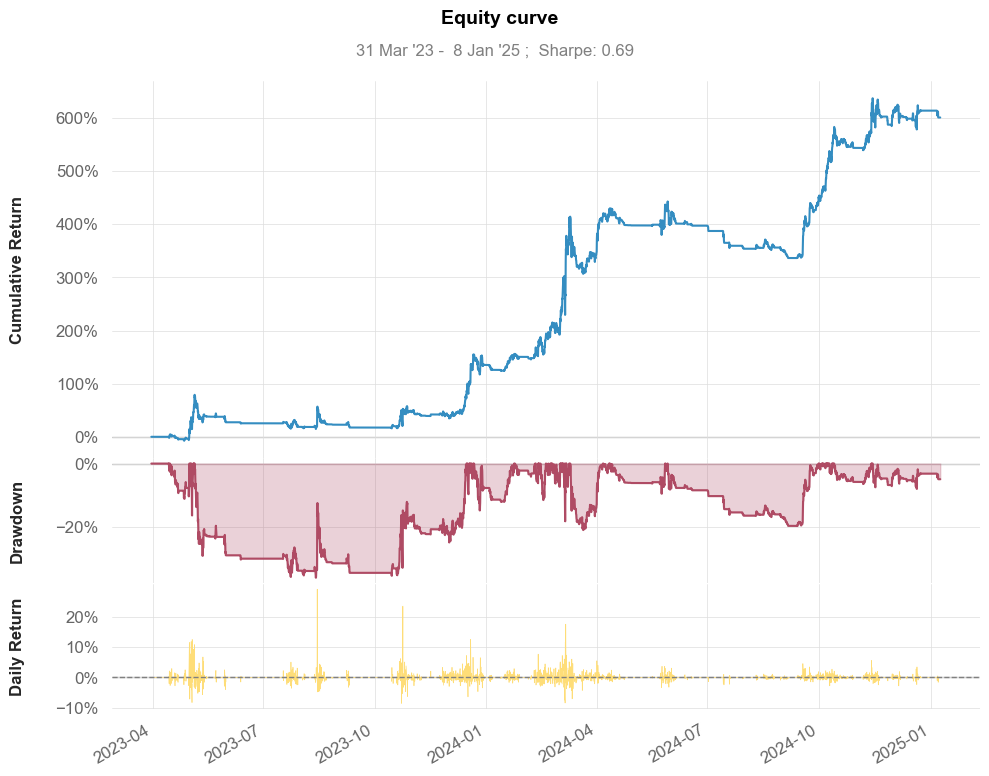

In [16]:
from tradeexecutor.visual.equity_curve import calculate_equity_curve, calculate_returns
from tradeexecutor.visual.equity_curve import visualise_equity_curve

curve = calculate_equity_curve(state)
returns = calculate_returns(curve)
fig = visualise_equity_curve(returns)
display(fig)

# Asset weights

- What assets were allocated over time
- Do both proportional % and USD weights

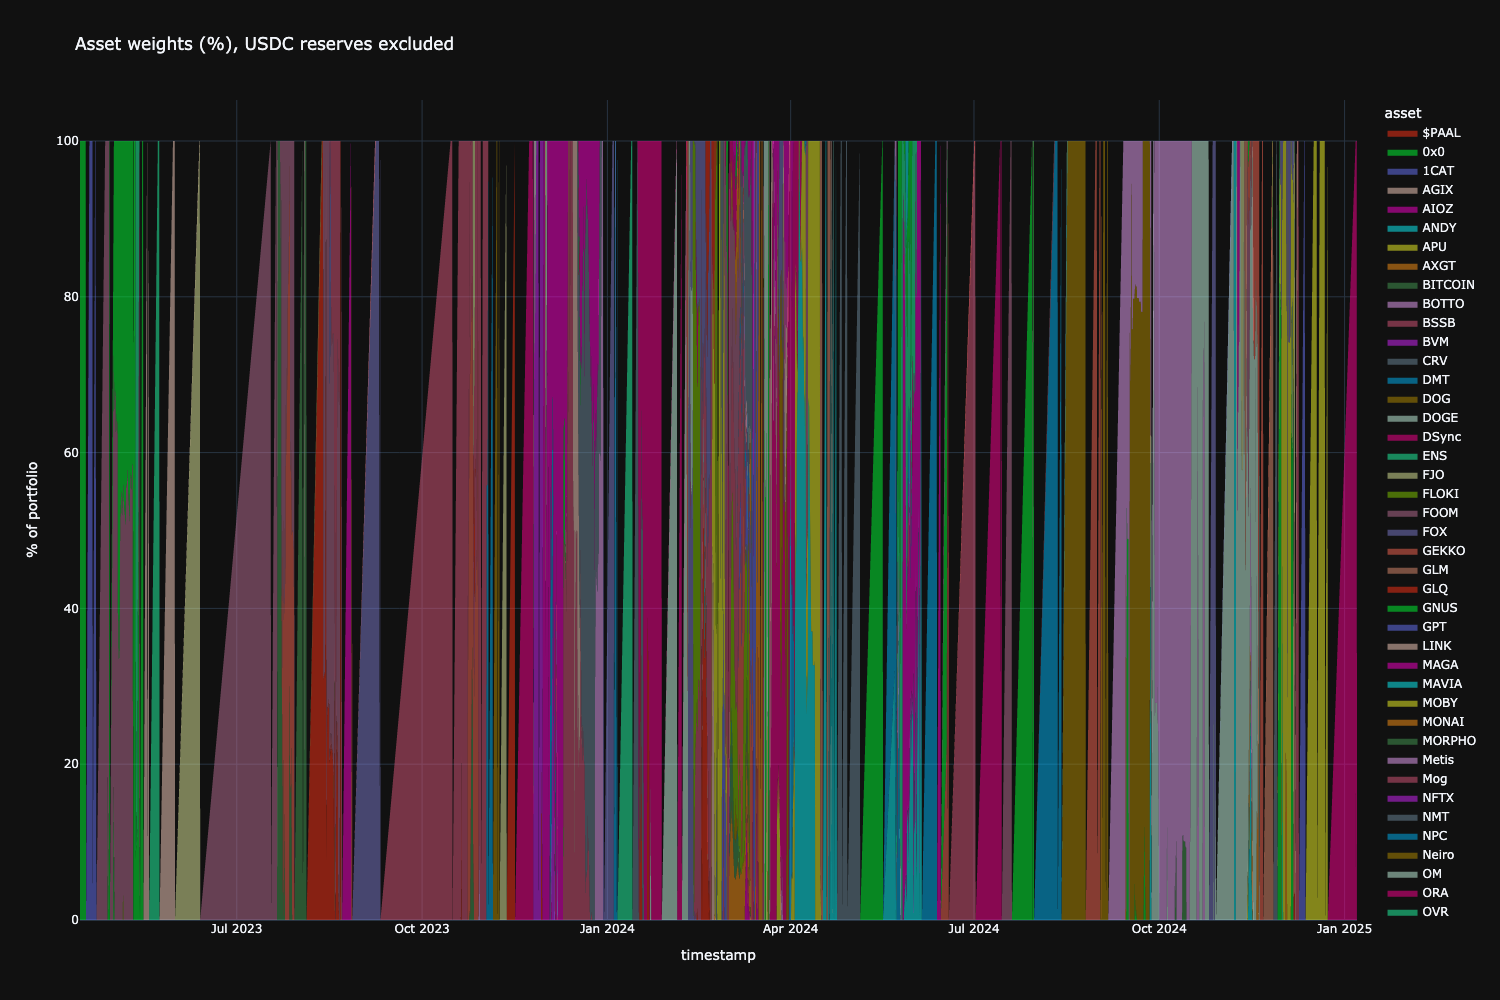

In [17]:
from tradeexecutor.analysis.weights import calculate_asset_weights, visualise_weights

weights_series = calculate_asset_weights(state)

fig = visualise_weights(
    weights_series,
    normalised=True,
    include_reserves=False,
)
fig.show()

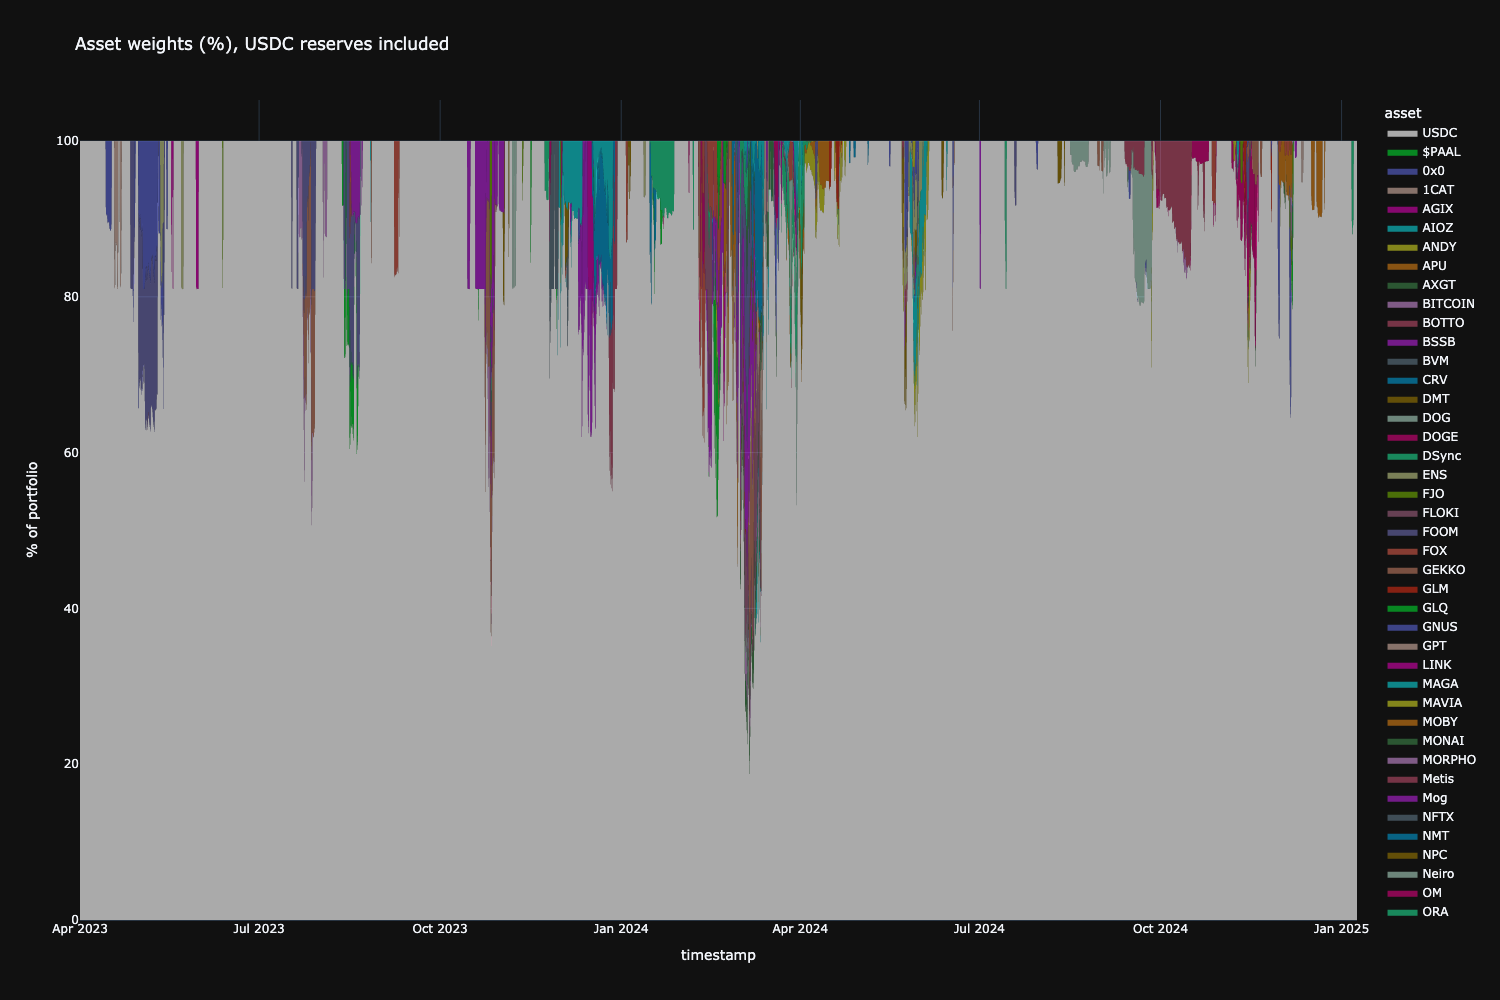

In [18]:

fig = visualise_weights(
    weights_series,
    normalised=True,
    include_reserves=True,
)
fig.show()

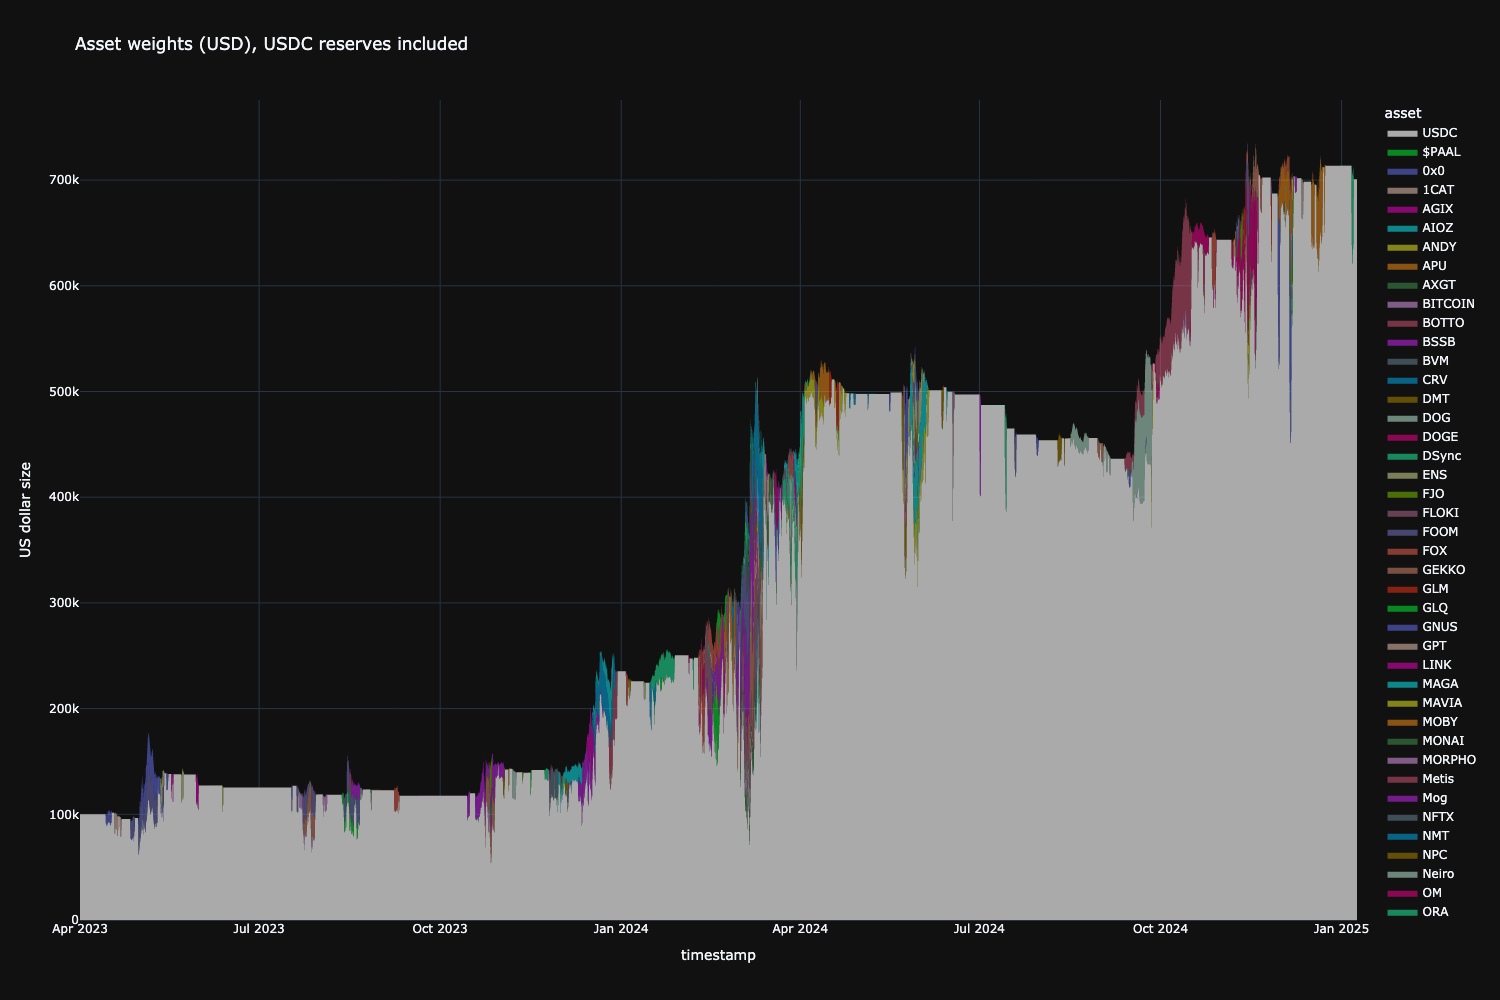

In [19]:
df = weights_series.unstack(level=1)

fig = visualise_weights(
    weights_series,
    normalised=False,
)
fig.show()

## Weight allocation statistics



In [20]:
from tradeexecutor.analysis.weights import calculate_weights_statistics

stats = calculate_weights_statistics(weights_series)
display(stats)


At   Pair       Value Unit
Name                                                                       
Max position (excluding USDC)   2024-12-05 12:00:00    0x0  153,677.73  USD
Min position (excluding USDC)   2023-10-29 00:00:00  BOTTO       96.69  USD
Mean position (excluding USDC)                               28,050.06  USD
Max position (excluding USDC)   2023-04-14 04:00:00    0x0      100.00    %
Min position (excluding USDC)   2024-05-29 00:00:00   NFTX        0.54    %
Mean position (excluding USDC)                                   48.34    %
Max position (including USDC)   2023-04-01 00:00:00   USDC      100.00    %
Min position (including USDC)   2024-11-27 20:00:00    NMT        0.01    %
Mean position (including USDC)                                   51.01    %

# Positions at the end

Some example positions at the end


In [21]:

for p in list(state.portfolio.open_positions.values())[0:10]:
    print(f"Position {p.pair.base.token_symbol}, value {p.get_value()} USD")

Examples of strategy thinking output 

- At the end of strategy
- Reverse order - last timestamp first

In [22]:
messages = state.visualisation.get_messages_tail(2)

table = pd.Series(
    data=list(messages.values()),
    index=list(messages.keys()),
)

df = table.to_frame()

display(df.style.set_properties(**{
    'text-align': 'left',
    'white-space': 'pre-wrap',
}))


# Alpha model diagnostics data

- Dump out alpha model contents from the last cycle

In [23]:
from tradeexecutor.strategy.alpha_model import format_signals

alpha_model = state.visualisation.discardable_data["alpha_model"]

print(f"All signals ({len(df)})")
df = format_signals(alpha_model, signal_type="all")
display(df)

All signals (2)


Empty DataFrame
Columns: []
Index: []

# Trading pair breakdown

- Trade success for each trading pair



In [24]:
from tradeexecutor.analysis.multipair import analyse_multipair
from tradeexecutor.analysis.multipair import format_multipair_summary

multipair_summary = analyse_multipair(state)
format_multipair_summary(multipair_summary, sort_column="Total return %")

# Trading metrics

- Trading cost, etc.

In [25]:
from tradeexecutor.analysis.trade_analyser import build_trade_analysis

analysis = build_trade_analysis(state.portfolio)
summary = analysis.calculate_summary_statistics()
display(summary.to_dataframe())

# Credit metrics

- How much we get out from Aave

In [26]:
from tradeexecutor.analysis.credit import calculate_credit_metrics

interest_df = calculate_credit_metrics(state)
display(interest_df)

Value
Name                        
Credit position count      0